## Experiments: Diabetes Retinopathy

<img src = 'https://repository-images.githubusercontent.com/195603342/63983100-b4a6-11e9-846c-99b9465f7b3b'>

In [1]:
from collections import Counter

from docarray.typing import TorchTensor, TorchEmbedding, ImageUrl
from typing import Optional
from docarray.documents import ImageDoc
from docarray import BaseDoc, DocVec, DocList
from docarray.typing import ID

class MultiModal(BaseDoc):
    embedding: TorchTensor
    path: ImageUrl
    label: int
    label_description: str
    zeroshot_label: int
    zeroshot_description: str
    task: int
    task_description: str
    id_code: str
    metadata: dict

In [2]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import metrics
import numpy as np
# from torchvision import transforms
import torch
import clip
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from rich import print
from scipy.stats import trim_mean

from sklearn.metrics.pairwise import cosine_similarity


def stratified_sampling(docs: DocList[MultiModal], zeroshot_labels, n_neighbors=10):

    # Create a list to store nearest docs
    sampled_docs = []

    # For each unique class in labels
    for i in np.unique(zeroshot_labels):
        # Filter instances belonging to current class
        class_docs = [doc for doc, label in zip(docs, zeroshot_labels) if label == i]

        # Sample n_samples_per_class from current class_docs
        if len(class_docs) > n_neighbors:
            sampled_docs += np.random.choice(class_docs, n_neighbors, replace=False).tolist()
        else:
            # Maybe the under-represented classes are the wrong one
            sampled_docs += class_docs


    return DocList[MultiModal](sampled_docs)

def zeroshot_clustering(docs: DocList[MultiModal], text_embs, labels_prompts):
    # Convert embeddings to a stack of tensors
    image_embs = torch.stack([doc.embedding for doc in docs])
    image_embs /= image_embs.norm(dim=-1, keepdim=True)
    
    text_emb = text_embs.clone()
    text_emb /= text_emb.norm(dim=-1, keepdim=True)
    
    print(f"image_embs: {image_embs.shape}")
    print(f"text_emb: {text_emb.shape}")
    
    # Compute the similarity matrix between all image embeddings and text embeddings
    similarity = (100.0 * image_embs @ text_emb.T).softmax(dim=-1)
    
    # Find the index of the label with maximum similarity for each image embedding
    zeroshot_labels = torch.argmax(similarity, dim=1).numpy()

    # Number of unique labels
    n_clusters_ = len(set(zeroshot_labels))

    print("Estimated number of clusters: %d" % n_clusters_)
    print(f"Counter zero-shot labels = {Counter(zeroshot_labels)}")
    # print(f"Unique labels = {np.unique(labels)}")
    
    new_docs = DocList[MultiModal](docs)
    new_docs.zeroshot_label = zeroshot_labels
    new_docs.zeroshot_description = [labels_prompts[i] for i in zeroshot_labels]
    
    return new_docs, zeroshot_labels, n_clusters_

def get_zeroshot_sampling(docs: DocList[MultiModal], text_embs, labels_prompts, n_neighbors=10):
    
    #1. Get the CLIP embeddings
    x = torch.stack([doc.embedding for doc in docs])
    
    #2. zero-shot clustering the embeddings
    clustered_docs, zeroshot_labels, n_clusters = zeroshot_clustering(docs, text_embs, labels_prompts)

    #3. Get stratified samples
    sampled_docs = stratified_sampling(clustered_docs, zeroshot_labels, n_neighbors)

    print(f"# Sampled docs ({round((len(sampled_docs) / len(clustered_docs)) * 100, 2)}%):", len(sampled_docs))
    print()

    return clustered_docs, sampled_docs 


## Pulling docs

In [3]:
%%time

url = 'file://./indian_domains'
dl = DocList[MultiModal].pull(url)
dl.summary()

╭──────── DocList Summary ─────────╮
│                                  │
│   Type     DocList[MultiModal]   │
│   Length   7324                  │
│                                  │
╰──────────────────────────────────╯

╭───────── Document Schema ─────────╮
│                                   │
│   MultiModal                      │
│   ├── embedding: TorchTensor      │
│   ├── path: ImageUrl              │
│   ├── label: int                  │
│   ├── label_description: str      │
│   ├── zeroshot_label: int         │
│   ├── zeroshot_description: str   │
│   ├── task: int                   │
│   ├── task_description: str       │
│   ├── id_code: str                │
│   └── metadata: dict              │
│                                   │
╰───────────────────────────────────╯

CPU times: user 4.78 s, sys: 380 ms, total: 5.16 s
Wall time: 5.16 s


In [4]:
print(f"Task: {Counter(dl.task)}")
print(f"Task description: {Counter(dl.task_description)}")

print(f"Label: {Counter(dl.label)}")
print(f"Label description: {Counter(dl.label_description)}")

dl[0]

Task: Counter({2: 3662, 1: 2622, 0: 1040})

Task description: Counter({'Gaussian Noise': 3662, 'Fundus photograph with some variation in lighting': 2622, 
'Fundus photograph with uniform image quality': 1040})

Label: Counter({1: 3714, 0: 3610})

Label description: Counter({'Retinopathy': 3714, 'No retinopathy': 3610})

📄 MultiModal : b8e664e ...
╭───────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────╮
│ Attribute                 │ Value                                                                               │
├───────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────┤
│ embedding: TorchTensor    │ TorchTensor of shape (768,), dtype: torch.float32                                   │
│ path: ImageUrl            │ /home/guess/indian_retinopathy/data/train_images/0 ... (length: 65)                 │
│ label: int                │ 1                                                                                   │
│ label_description: str    │ Retinopathy                                                                         │
│ zeroshot_label: int       │ -1                                                                                  │
│ zeroshot_description: str │                                                                                     │
│ task: int                 │ 1                                                                                   │
│ task_description: str     │ Fundus photograph with some variation in lighting                                   │
│ id_code: str              │ 000c1434d8d7                                                                        │
│ metadata: dict            │ {}                                                                                  │
╰───────────────────────────┴─────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
# from docarray.data import MultiModalDataset

list_doclists = list()
unique_tasks = np.unique(dl.task)

for task in unique_tasks:
    doc_list = DocList[MultiModal]([doc for doc in dl if doc.task == task])
    list_doclists.append(doc_list)
    
list_doclists

[<DocList[MultiModal] (length=1040)>,
 <DocList[MultiModal] (length=2622)>,
 <DocList[MultiModal] (length=3662)>]

## Visualize clusters

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Device: {device}")
embeder, preprocess = clip.load("ViT-L/14@336px", device=device)

Device: cpu

In [ ]:
class_labels = {
    0: 'No retinopathy', 
    1: 'Retinopathy'
}

In [ ]:
def get_label_tokens(embeder, labels_prompts):

    print(labels_prompts)
    label_tokens = clip.tokenize(labels_prompts)
    with torch.no_grad():
        text_embs = embeder.encode_text(label_tokens)
    return text_embs

# text_embs = get_label_tokens(embeder, labels_prompts)

# print(text_embs.shape)

In [9]:
# description_sets_short = [

#     {
#         'No retinopathy': 'Healthy retina',
#         'Retinopathy': 'Diabetic damage'
#     },
#     # Short Alternative 2
#     {
#         'No retinopathy': 'No damage',
#         'Retinopathy': 'Diabetic signs'
#     },
#     # Short Alternative 3
#     {
#         'No retinopathy': 'Normal retina',
#         'Retinopathy': 'Retinal disease'
#     },
#     # Short Alternative 4
#     {
#         'No retinopathy': 'No issues',
#         'Retinopathy': 'Retinopathy present'
#     },
#     # Short Alternative 5
#     {
#         'No retinopathy': 'Clear fundus',
#         'Retinopathy': 'Fundus changes'
#     }
# ]

# templates = [
#     "an iris with", 
#     "a human eye with", 
#     "", 
#     "an ocular image with", 
#     "a retinal photo with",
#     "A fundus image displaying",
#     "Visible symptoms in the retina suggest",
#     "Retinal scan reveals",
#     "Optical image shows",
#     "The condition of the retina is"
# ]

In [10]:
from langchain_openai import ChatOpenAI
import json


def setup_medgemma():
    """Initialize Med-Gemma through LM Studio"""
    llm = ChatOpenAI(
        base_url="http://172.27.144.1:1234/v1",
        api_key="lm-studio",
        model="med-gemma",
        temperature=0.7,
        max_tokens=300
    )
    return llm

llm = setup_medgemma()
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7f6a233db940>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7f6a23324f40>, root_client=<openai.OpenAI object at 0x7f6a2ba12730>, root_async_client=<openai.AsyncOpenAI object at 0x7f6a233db970>, model_name='med-gemma', openai_api_key=SecretStr('**********'), openai_api_base='http://172.27.144.1:1234/v1', openai_proxy='', max_tokens=300)

In [11]:
llm.invoke("hi. give me a poem?").content

"The wind whispers secrets through the trees,\nA rustling symphony carried on the breeze.\nSunlight paints the leaves in shades of gold and green,\nA fleeting masterpiece, a vibrant, silent scene.\n\nThe river flows onward, a silver ribbon bright,\nReflecting skies above with all its gentle might.\nAnd wildflowers bloom along the water's edge so near,\nTheir fragile beauty whispers hope to every ear.\n\nBut shadows lengthen as the day begins to wane,\nA quiet stillness settles on the land again.\nThe stars begin to glimmer in the darkening sky,\nAs nature slumbers softly 'neath a watchful eye.\n\nAnd though the world may seem to fade and disappear,\nThere's beauty still to find, both far and ever near.\nSo breathe it in, this moment, precious and serene,\nFor even in the darkness, life is always seen.\n"

In [12]:
current_template = ""  # Empty template
current_descriptions = {'No retinopathy': 'healthy', 'Retinopathy': 'diseased'}

## APE: Adaptive prompting evolution

In [ ]:
# Enhanced APE with Complete Tracking & Customization
# Replace all your APE functions with these enhanced versions

from langchain_openai import ChatOpenAI
import json
import time

# ===== ENHANCED APE WITH FULL TRACKING =====

class APETracker:
    """Class to track all APE evolution data for analysis and plotting"""
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        """Reset all tracking data"""
        self.evolution_history = []
        self.all_candidates = []
        self.iteration_stats = []
        self.start_time = None
        self.end_time = None
        self.target_score = None
        self.baseline_scores = {}
        
    def start_tracking(self, initial_state, target_score=None, baseline_scores=None):
        """Initialize tracking with starting state"""
        self.start_time = time.time()
        self.target_score = target_score
        self.baseline_scores = baseline_scores or {}
        
        # Record initial state
        self.evolution_history.append({
            'iteration': 0,
            'template': initial_state['template'],
            'descriptions': initial_state['descriptions'].copy(),
            'f1': initial_state['f1'],
            'improvement': 0.0,
            'is_best': True,
            'timestamp': time.time() - self.start_time
        })
        
    def add_candidates(self, iteration, candidates, evaluations):
        """Record all candidates from an iteration"""
        for i, (candidate, f1_score) in enumerate(zip(candidates, evaluations)):
            self.all_candidates.append({
                'iteration': iteration,
                'candidate_id': i + 1,
                'template': candidate['template'],
                'descriptions': candidate['descriptions'].copy(),
                'f1': f1_score,
                'improvement': f1_score - self.evolution_history[-1]['f1'],
                'timestamp': time.time() - self.start_time
            })
    
    def add_evolution_step(self, iteration, new_state, improvement):
        """Record a successful evolution step"""
        self.evolution_history.append({
            'iteration': iteration,
            'template': new_state['template'],
            'descriptions': new_state['descriptions'].copy(),
            'f1': new_state['f1'],
            'improvement': improvement,
            'is_best': True,
            'timestamp': time.time() - self.start_time
        })
        
    def add_iteration_stats(self, iteration, stats):
        """Record iteration statistics"""
        stats['iteration'] = iteration
        stats['timestamp'] = time.time() - self.start_time
        self.iteration_stats.append(stats)
        
    def finish_tracking(self):
        """Finalize tracking"""
        self.end_time = time.time()
        
    def get_summary(self):
        """Get complete tracking summary"""
        total_time = (self.end_time - self.start_time) if self.end_time else 0
        
        return {
            'evolution_history': self.evolution_history,
            'all_candidates': self.all_candidates,
            'iteration_stats': self.iteration_stats,
            'summary': {
                'total_time': total_time,
                'total_candidates': len(self.all_candidates),
                'evolution_steps': len(self.evolution_history) - 1,
                'starting_f1': self.evolution_history[0]['f1'],
                'final_f1': self.evolution_history[-1]['f1'],
                'total_improvement': self.evolution_history[-1]['f1'] - self.evolution_history[0]['f1'],
                'target_score': self.target_score,
                'target_achieved': self.evolution_history[-1]['f1'] >= (self.target_score or 0),
                'baseline_scores': self.baseline_scores
            }
        }

# def setup_medgemma():
#     """Initialize Med-Gemma through LM Studio"""
#     llm = ChatOpenAI(
#         base_url="http://172.27.144.1:1234/v1",
#         api_key="lm-studio",
#         model="med-gemma",
#         temperature=0.7,
#         max_tokens=300
#     )
#     return llm

def evaluate_single_prompt(template, descriptions, task_data):
    """Evaluate a single template + description combination"""
    labels_prompts = [f"{template} {descriptions[c]}" for c in class_labels.values()]
    text_embs = get_label_tokens(embeder, labels_prompts)
    clustered_docs, sampled_docs = get_zeroshot_sampling(task_data, text_embs, labels_prompts, n_neighbors=10)
    
    ground_truth_labels = clustered_docs.label
    zeroshot_labels = clustered_docs.zeroshot_label
    f1 = metrics.f1_score(ground_truth_labels, zeroshot_labels, average='weighted')
    
    return f1

def generate_template_and_descriptions_tracked(current_template, current_descriptions, current_f1, num_candidates=5):
    """Generate new template AND description combinations using Med-Gemma"""
    print(f"\n🤖 Generating {num_candidates} new template+description combinations...")
    print(f"Current best F1: {current_f1:.4f}")
    
    llm = setup_medgemma()
    
    prompt = f"""
You are a medical expert creating optimal text prompts for diabetic retinopathy classification using AI vision models.

CURRENT BEST (F1={current_f1:.3f}):
Template: "{current_template}"
Healthy: "{current_descriptions['No retinopathy']}"  
Diseased: "{current_descriptions['Retinopathy']}"

TASK: Generate {num_candidates} NEW template+description combinations that could beat F1={current_f1:.3f}

REQUIREMENTS:
- Include BOTH template and descriptions
- Keep ALL text SHORT (2-4 words max per description)  
- Use medical terminology that AI vision models understand
- Focus on visual features visible in fundus images
- Templates should help contextualize the descriptions

GOOD EXAMPLES:
- Template: "Fundus image shows" + Healthy: "Normal retina" + Diseased: "DR present"
- Template: "Retinal scan reveals" + Healthy: "Healthy fundus" + Diseased: "Diabetic damage"
- Template: "" + Healthy: "Clear vessels" + Diseased: "Retinal lesions"

Return EXACTLY this JSON format:
[
  {{"template": "template1", "healthy": "healthy1", "diseased": "diseased1"}},
  {{"template": "template2", "healthy": "healthy2", "diseased": "diseased2"}},
  {{"template": "template3", "healthy": "healthy3", "diseased": "diseased3"}},
  {{"template": "template4", "healthy": "healthy4", "diseased": "diseased4"}},
  {{"template": "template5", "healthy": "healthy5", "diseased": "diseased5"}}
]
"""
    
    try:
        response = llm.invoke(prompt)
        
        response_text = response.content
        
        # Extract JSON from response
        start_idx = response_text.find('[')
        end_idx = response_text.rfind(']') + 1
        json_text = response_text[start_idx:end_idx]
        
        combinations_list = json.loads(json_text)
        
        # Convert to your format and filter for short text
        candidates = []
        for combo in combinations_list[:num_candidates]:
            template = combo.get('template', '').strip()
            healthy = combo.get('healthy', '').strip()
            diseased = combo.get('diseased', '').strip()
            
            # Filter for short descriptions (CLIP works better with short text)
            if len(healthy.split()) <= 4 and len(diseased.split()) <= 4:
                candidates.append({
                    'template': template,
                    'descriptions': {
                        'No retinopathy': healthy,
                        'Retinopathy': diseased
                    }
                })
        
        print(f"Generated {len(candidates)} valid combinations")
        return candidates
        
    except Exception as e:
        print(f"Med-Gemma generation failed: {e}")
        return []

def evaluate_template_combinations_tracked(candidates, task_data, current_f1, tracker, iteration):
    """Evaluate all template+description candidates with tracking"""
    print(f"\n📊 Evaluating {len(candidates)} template+description combinations...")
    
    # Evaluate all candidates
    evaluations = []
    for candidate in candidates:
        f1_score = evaluate_single_prompt(candidate['template'], candidate['descriptions'], task_data)
        evaluations.append(f1_score)
    
    # Track all candidates
    tracker.add_candidates(iteration, candidates, evaluations)
    
    # Find best candidate
    best_f1 = current_f1
    best_template = None
    best_descriptions = None
    improved = False
    best_candidate_idx = -1
    
    for i, (candidate, f1_score) in enumerate(zip(candidates, evaluations)):
        template = candidate['template']
        descriptions = candidate['descriptions']
        
        print(f"  Candidate {i+1}: F1={f1_score:.4f} | Template: '{template}' | {descriptions}")
        
        if f1_score > best_f1:
            print(f"  🎉 NEW BEST! Improvement: +{f1_score - best_f1:.4f}")
            best_f1 = f1_score
            best_template = template
            best_descriptions = descriptions
            improved = True
            best_candidate_idx = i
    
    # Track iteration statistics
    iteration_stats = {
        'num_candidates': len(candidates),
        'best_f1': max(evaluations),
        'worst_f1': min(evaluations),
        'avg_f1': sum(evaluations) / len(evaluations),
        'std_f1': (sum([(f1 - sum(evaluations)/len(evaluations))**2 for f1 in evaluations]) / len(evaluations))**0.5,
        'improvements': sum(1 for f1 in evaluations if f1 > current_f1),
        'best_candidate_idx': best_candidate_idx
    }
    tracker.add_iteration_stats(iteration, iteration_stats)
    
    return best_f1, best_template, best_descriptions, improved

def autonomous_ape_optimization_enhanced_v2(
    task_0_data, 
    max_iterations=7, 
    candidates_per_iteration=5,
    target_score=None,
    patience=3,
    starting_template="",
    starting_descriptions=None,
    baseline_scores=None,
    verbose=True,
    stop_on_target=False  # NEW PARAMETER: Whether to stop when target is achieved
):
    """
    Enhanced autonomous APE optimization with option to continue past target for better generalization
    
    Args:
        task_0_data: Your Task 0 dataset with ground truth
        max_iterations: Maximum evolution cycles
        candidates_per_iteration: Number of candidates per iteration
        target_score: Target F1 score to track (but won't stop early unless stop_on_target=True)
        patience: Number of iterations without improvement before stopping
        starting_template: Initial template (default: "")
        starting_descriptions: Initial descriptions (default: basic ones)
        baseline_scores: Dictionary of baseline scores for comparison
        verbose: Whether to print detailed progress
        stop_on_target: If True, stops when target is achieved; If False, continues to max_iterations
    
    Returns:
        Dictionary with evolved results and complete tracking data
    """
    # Initialize tracker
    tracker = APETracker()
    
    if verbose:
        print("🚀 Starting Enhanced Autonomous APE Optimization v2")
        print("=" * 60)
    
    # Set defaults
    if starting_descriptions is None:
        starting_descriptions = {'No retinopathy': 'healthy', 'Retinopathy': 'diseased'}
    
    if baseline_scores is None:
        baseline_scores = {'exhaustive_search': 0.8921}  # Default baseline
    
    # START FROM SPECIFIED STARTING POINT
    current_template = starting_template
    current_descriptions = starting_descriptions.copy()
    
    # Evaluate starting point
    if verbose:
        print("🌱 Evaluating starting point...")
    current_f1 = evaluate_single_prompt(current_template, current_descriptions, task_0_data)
    
    # Initialize tracking
    initial_state = {
        'template': current_template,
        'descriptions': current_descriptions,
        'f1': current_f1
    }
    tracker.start_tracking(initial_state, target_score, baseline_scores)
    
    if verbose:
        print(f"\n📍 STARTING CONFIGURATION:")
        print(f"  Template: '{current_template}' {'(empty)' if not current_template else ''}")
        print(f"  Descriptions: {current_descriptions}")
        print(f"  Starting F1: {current_f1:.4f}")
        if target_score:
            print(f"  🎯 Target: Beat F1 > {target_score:.4f}")
            print(f"  🔄 Stop on target: {'Yes' if stop_on_target else 'No (continue for generalization)'}")
        print(f"  🔄 Max iterations: {max_iterations}")
        print(f"  ⏱️ Patience: {patience} iterations")
    
    consecutive_no_improvement = 0
    target_achieved_iteration = None
    
    for iteration in range(max_iterations):
        if verbose:
            print(f"\n" + "="*50)
            print(f"🧬 EVOLUTION ITERATION {iteration + 1}/{max_iterations}")
            print(f"="*50)
            print(f"Current best F1: {current_f1:.4f}")
        
        # Check if target achieved (but don't stop unless stop_on_target=True)
        if target_score and current_f1 >= target_score:
            if target_achieved_iteration is None:
                target_achieved_iteration = iteration + 1
                if verbose:
                    print(f"🎯 TARGET ACHIEVED! F1={current_f1:.4f} >= {target_score:.4f}")
                    if stop_on_target:
                        print("🛑 Stopping early due to target achievement")
                        break
                    else:
                        print("🔄 Continuing evolution for better generalization...")
        
        # Step 1: Generate new template+description combinations
        candidates = generate_template_and_descriptions_tracked(
            current_template, current_descriptions, current_f1, 
            num_candidates=candidates_per_iteration
        )
        
        if not candidates:
            if verbose:
                print("❌ No valid candidates generated, stopping early")
            break
        
        # Step 2: Evaluate all combinations with tracking
        new_f1, new_template, new_descriptions, improved = evaluate_template_combinations_tracked(
            candidates, task_0_data, current_f1, tracker, iteration + 1
        )
        
        # Step 3: Evolution decision
        if improved:
            previous_f1 = current_f1
            current_f1 = new_f1
            current_template = new_template
            current_descriptions = new_descriptions
            consecutive_no_improvement = 0
            
            improvement = current_f1 - previous_f1
            
            if verbose:
                print(f"\n🎉 EVOLUTION SUCCESS!")
                print(f"   Previous F1: {previous_f1:.4f}")
                print(f"   New F1: {current_f1:.4f}")
                print(f"   Improvement: +{improvement:.4f}")
                print(f"   New template: '{current_template}'")
                print(f"   New descriptions: {current_descriptions}")
            
            # Track evolution step
            tracker.add_evolution_step(iteration + 1, {
                'template': current_template,
                'descriptions': current_descriptions,
                'f1': current_f1
            }, improvement)
            
        else:
            consecutive_no_improvement += 1
            if verbose:
                print(f"\n📊 No improvement in iteration {iteration + 1}")
                print(f"   Consecutive no improvement: {consecutive_no_improvement}")
                print(f"   Current best remains: {current_f1:.4f}")
            
            # Early stopping check (only based on patience, not target)
            if consecutive_no_improvement >= patience:
                if verbose:
                    print(f"\n🛑 Early stopping: No improvement for {patience} iterations")
                break
    
    # Finalize tracking
    tracker.finish_tracking()
    tracking_data = tracker.get_summary()
    
    # Add target achievement info
    tracking_data['summary']['target_achieved_iteration'] = target_achieved_iteration
    
    if verbose:
        print(f"\n" + "="*60)
        print("🧬 ENHANCED APE EVOLUTION COMPLETE")
        print("="*60)
        
        # Print evolution trajectory
        print("📈 Evolution Trajectory:")
        for step in tracking_data['evolution_history']:
            if step['iteration'] == 0:
                print(f"  Start: F1={step['f1']:.4f} | '{step['template']}' + {step['descriptions']}")
            else:
                print(f"  Step {step['iteration']}: F1={step['f1']:.4f} (+{step['improvement']:.4f}) | '{step['template']}' + {step['descriptions']}")
        
        # Print final statistics
        summary = tracking_data['summary']
        print(f"\n📊 Final Statistics:")
        print(f"  Total candidates tested: {summary['total_candidates']}")
        print(f"  Evolution steps: {summary['evolution_steps']}")
        print(f"  Starting F1: {summary['starting_f1']:.4f}")
        print(f"  Final F1: {summary['final_f1']:.4f}")
        print(f"  Total improvement: +{summary['total_improvement']:.4f}")
        print(f"  Total time: {summary['total_time']:.1f} seconds")
        
        if target_achieved_iteration:
            print(f"  🎯 Target achieved at iteration: {target_achieved_iteration}")
            additional_iterations = len(tracking_data['evolution_history']) - 1 - target_achieved_iteration
            if additional_iterations > 0:
                print(f"  🔄 Additional iterations for generalization: {additional_iterations}")
        
        # Compare to baselines
        if baseline_scores:
            print(f"\n🏆 Baseline Comparisons:")
            for name, score in baseline_scores.items():
                if summary['final_f1'] >= score:
                    print(f"  ✅ {name}: {score:.4f} → APE beats by +{summary['final_f1'] - score:.4f}")
                else:
                    print(f"  📈 {name}: {score:.4f} → APE gap: -{score - summary['final_f1']:.4f}")
        
        if target_score:
            if summary['target_achieved']:
                print(f"  🎯 Target {target_score:.4f}: ✅ ACHIEVED!")
            else:
                print(f"  🎯 Target {target_score:.4f}: ❌ Gap: -{target_score - summary['final_f1']:.4f}")
    
    return {
        'template': current_template,
        'descriptions': current_descriptions,
        'f1_score': current_f1,
        'tracking_data': tracking_data
    }

def run_enhanced_autonomous_ape_v2(
    list_doclists,
    max_iterations=7,
    candidates_per_iteration=5,
    target_score=0.8921,
    patience=3,
    starting_template="",
    starting_descriptions=None,
    baseline_scores=None,
    stop_on_target=False  # NEW: Don't stop early for better generalization
):
    """
    Run enhanced autonomous APE optimization with better generalization
    """
    print("🚀 Starting Enhanced Autonomous APE v2 for All Tasks")
    print("🧬 Learning generalizable prompts (no early target stopping)")
    print("="*70)
    
    # Set default baseline scores
    if baseline_scores is None:
        baseline_scores = {
            'exhaustive_search': 0.8921,
            'exhaustive_task1': 0.8899,
            'exhaustive_task2': 0.8909
        }
    
    ape_results = {}
    
    for task_index, task in enumerate(list_doclists):
        print(f"\n" + "="*60)
        print(f"PROCESSING TASK {task_index}")
        print(f"="*60)
        
        if task_index == 0:
            # Run enhanced APE evolution on Task 0
            print("🧬 Running enhanced autonomous evolution on Task 0...")
            print("🔄 Will continue past target for better generalization...")
            
            ape_result = autonomous_ape_optimization_enhanced_v2(
                task, 
                max_iterations=max_iterations,
                candidates_per_iteration=candidates_per_iteration,
                target_score=target_score,
                patience=patience,
                starting_template=starting_template,
                starting_descriptions=starting_descriptions,
                baseline_scores=baseline_scores,
                stop_on_target=stop_on_target  # False by default for better generalization
            )
            
            ape_results[task_index] = ape_result
            
        else:
            # Transfer learned prompt to other tasks
            print(f"📋 Transferring learned prompt from Task 0 to Task {task_index}...")
            learned_prompt = ape_results[0]
            
            f1_score = evaluate_single_prompt(
                learned_prompt['template'],
                learned_prompt['descriptions'],
                task
            )
            
            ape_results[task_index] = {
                'template': learned_prompt['template'],
                'descriptions': learned_prompt['descriptions'],
                'f1_score': f1_score,
                'tracking_data': None  # No tracking for transfer
            }
            
            print(f"✅ Task {task_index} Results:")
            print(f"   Transfer F1: {f1_score:.4f}")
            
            # Compare to baseline
            baseline_key = f'exhaustive_task{task_index}'
            if baseline_key in baseline_scores:
                baseline_f1 = baseline_scores[baseline_key]
                if f1_score >= baseline_f1:
                    print(f"   🎉 Beats baseline: +{f1_score - baseline_f1:.4f}")
                else:
                    print(f"   📈 Below baseline: -{baseline_f1 - f1_score:.4f}")
    
    # Convert to best_values format for compatibility
    best_values = {}
    for task_index, result in ape_results.items():
        best_values[task_index] = {
            "best_score": result['f1_score'],
            "best_template": result['template'],
            "best_description_set": result['descriptions']
        }
    
    # Add tracking data for plotting
    best_values['ape_tracking'] = ape_results[0]['tracking_data']
    
    # Print final generalization summary
    print(f"\n" + "="*70)
    print("🎯 GENERALIZATION ANALYSIS")
    print("="*70)
    
    task_0_f1 = ape_results[0]['f1_score']
    transfer_f1s = [ape_results[i]['f1_score'] for i in range(1, len(list_doclists))]
    avg_transfer_f1 = sum(transfer_f1s) / len(transfer_f1s) if transfer_f1s else 0
    
    print(f"📊 Performance Summary:")
    print(f"  Task 0 (learning): {task_0_f1:.4f}")
    print(f"  Average transfer: {avg_transfer_f1:.4f}")
    print(f"  Transfer gap: {task_0_f1 - avg_transfer_f1:.4f}")
    
    # Compare transfer performance to baselines
    baseline_transfers = [baseline_scores.get(f'exhaustive_task{i}', 0.85) for i in range(1, len(list_doclists))]
    avg_baseline_transfer = sum(baseline_transfers) / len(baseline_transfers) if baseline_transfers else 0
    
    print(f"\n🏆 Transfer vs Baseline:")
    print(f"  APE average transfer: {avg_transfer_f1:.4f}")
    print(f"  Baseline average transfer: {avg_baseline_transfer:.4f}")
    if avg_transfer_f1 >= avg_baseline_transfer:
        print(f"  ✅ APE transfer beats baseline: +{avg_transfer_f1 - avg_baseline_transfer:.4f}")
    else:
        print(f"  📈 APE transfer below baseline: -{avg_baseline_transfer - avg_transfer_f1:.4f}")
    
    return best_values



In [ ]:
best_values = run_enhanced_autonomous_ape_v2(
    list_doclists,
    max_iterations=10,              # More iterations for generalization
    candidates_per_iteration=5,
    target_score=0.8921,          # Track but don't stop on target
    patience=6,                   # Only stop on no improvement
    stop_on_target=False          # KEY: Don't stop early on target
)

In [22]:
best_template = best_values[0]['best_template']
best_description_set = best_values[0]['best_description_set']

labels_prompts_best = [f"{best_template} {best_description_set[c]}" for c in class_labels.values()]
text_embs_best = get_label_tokens(embeder, labels_prompts_best)

print(f"Using APE-optimized prompts:")
print(f"Template: '{best_template}'")
print(f"Descriptions: {best_description_set}")

['Fundus image shows Normal retina', 'Fundus image shows Diabetic retinopathy present']

Using APE-optimized prompts:

Template: 'Fundus image shows'

Descriptions: {'No retinopathy': 'Normal retina', 'Retinopathy': 'Diabetic retinopathy present'}

## Save best_results from APE

In [179]:
import pickle
import datetime

# Generate version ID with timestamp
version_id = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'extension_plots/best_values_tracking_v{version_id}.pickle'

with open(filename, 'wb') as f:
    pickle.dump(best_values, f, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Saved best_values dictionary with prompt tracking to {filename}")

Saved best_values dictionary with prompt tracking to extension_plots/best_values_tracking_v20250617_101115.pickle

In [180]:
best_values

{0: {'best_score': 0.92289308661674,
  'best_template': 'Fundus image reveals',
  'best_description_set': {'No retinopathy': 'Normal retina',
   'Retinopathy': 'Diabetic retinopathy'}},
 1: {'best_score': 0.9172209168297761,
  'best_template': 'Fundus image reveals',
  'best_description_set': {'No retinopathy': 'Normal retina',
   'Retinopathy': 'Diabetic retinopathy'}},
 2: {'best_score': 0.9177703407599942,
  'best_template': 'Fundus image reveals',
  'best_description_set': {'No retinopathy': 'Normal retina',
   'Retinopathy': 'Diabetic retinopathy'}},
 'ape_tracking': {'evolution_history': [{'iteration': 0,
    'template': '',
    'descriptions': {'No retinopathy': 'healthy', 'Retinopathy': 'diseased'},
    'f1': 0.6145332420638315,
    'improvement': 0.0,
    'is_best': True,
    'timestamp': 4.5299530029296875e-06},
   {'iteration': 1,
    'template': 'Fundus image reveals',
    'descriptions': {'No retinopathy': 'Normal retina structure',
     'Retinopathy': 'Diabetic retinopath

In [181]:
best_values[0]['best_template']

'Fundus image reveals'

## Read best_values from APE

In [ ]:

import os
import glob

# Get all files in the directory
files = glob.glob('extension_plots/best_values_tracking_v*.pickle')
# Sort files by modification time
files.sort(key=os.path.getmtime, reverse=True)
# Load the most recent file
if files:
    latest_file = files[0]
    with open(latest_file, 'rb') as f:
        best_values = pickle.load(f)
    print(f"Loaded best_values from {latest_file}")
else:
    print("No best_values files found in the directory.")

print(f"Loaded {len(best_values)} best_values entries.")

🎨 Creating final extension plots for journal submission...

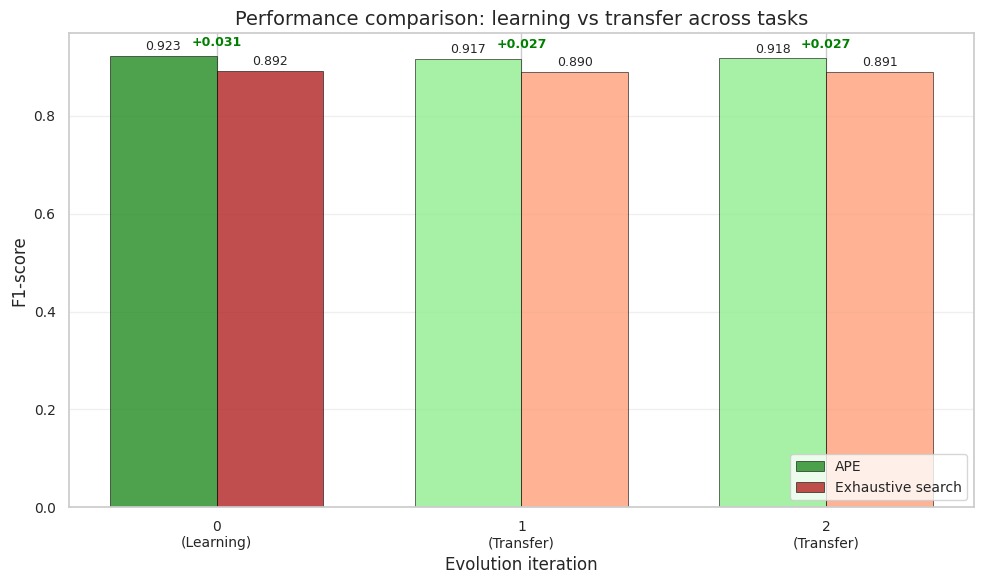

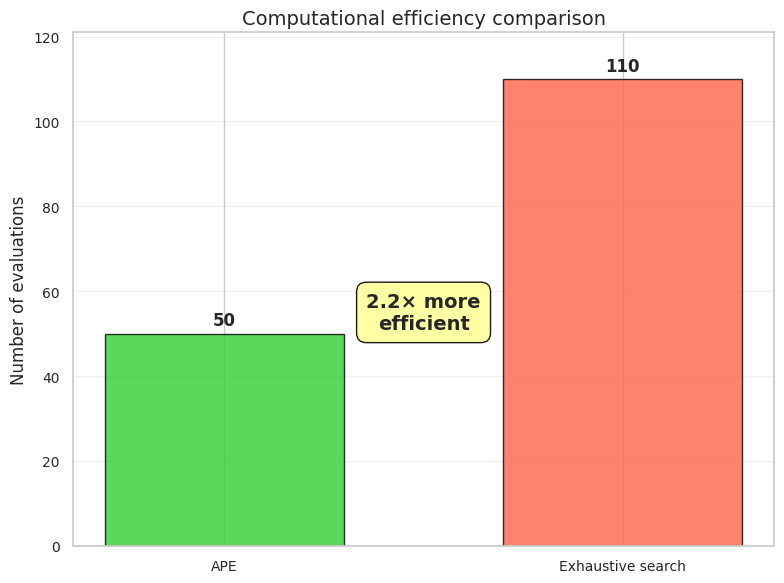

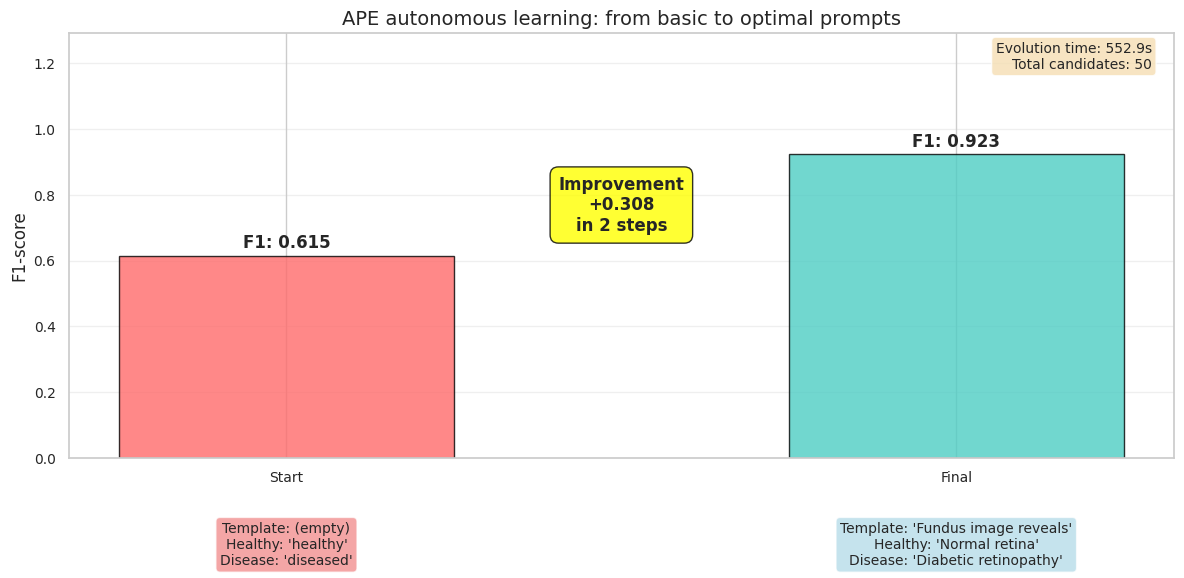

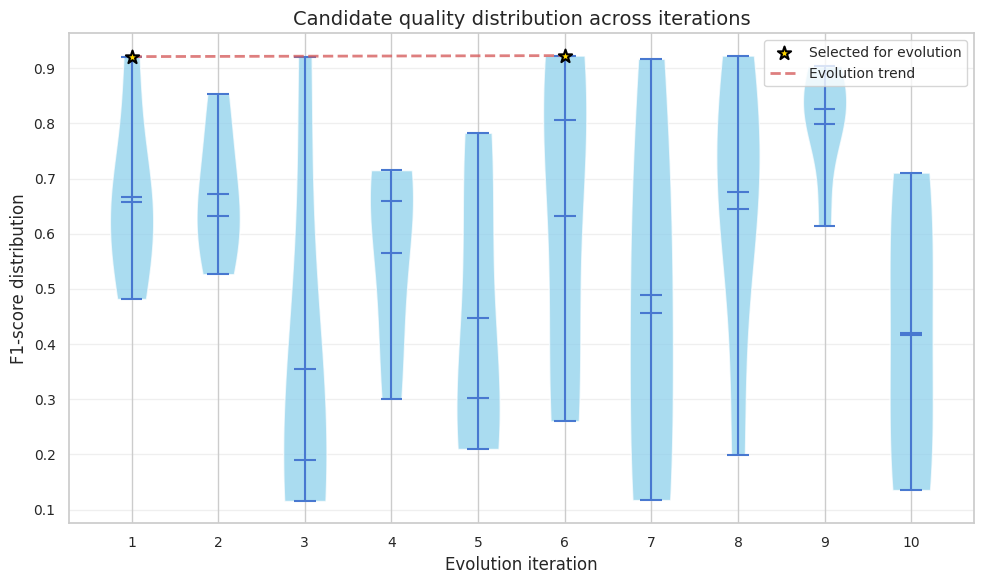

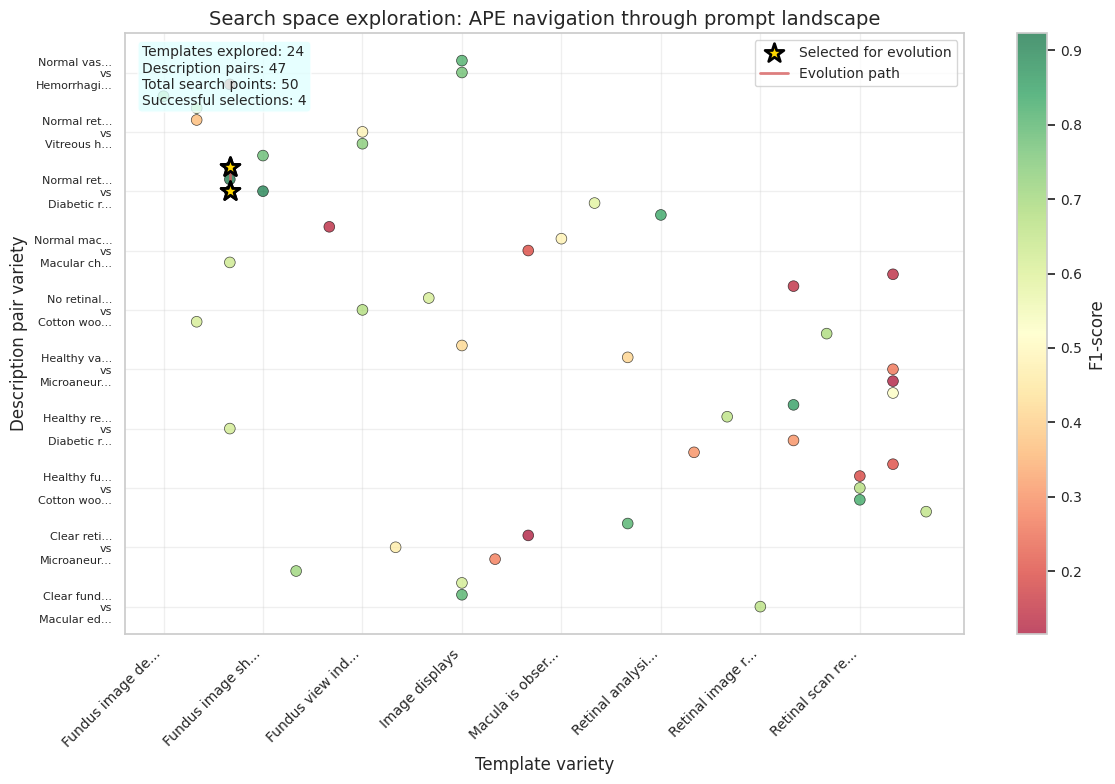

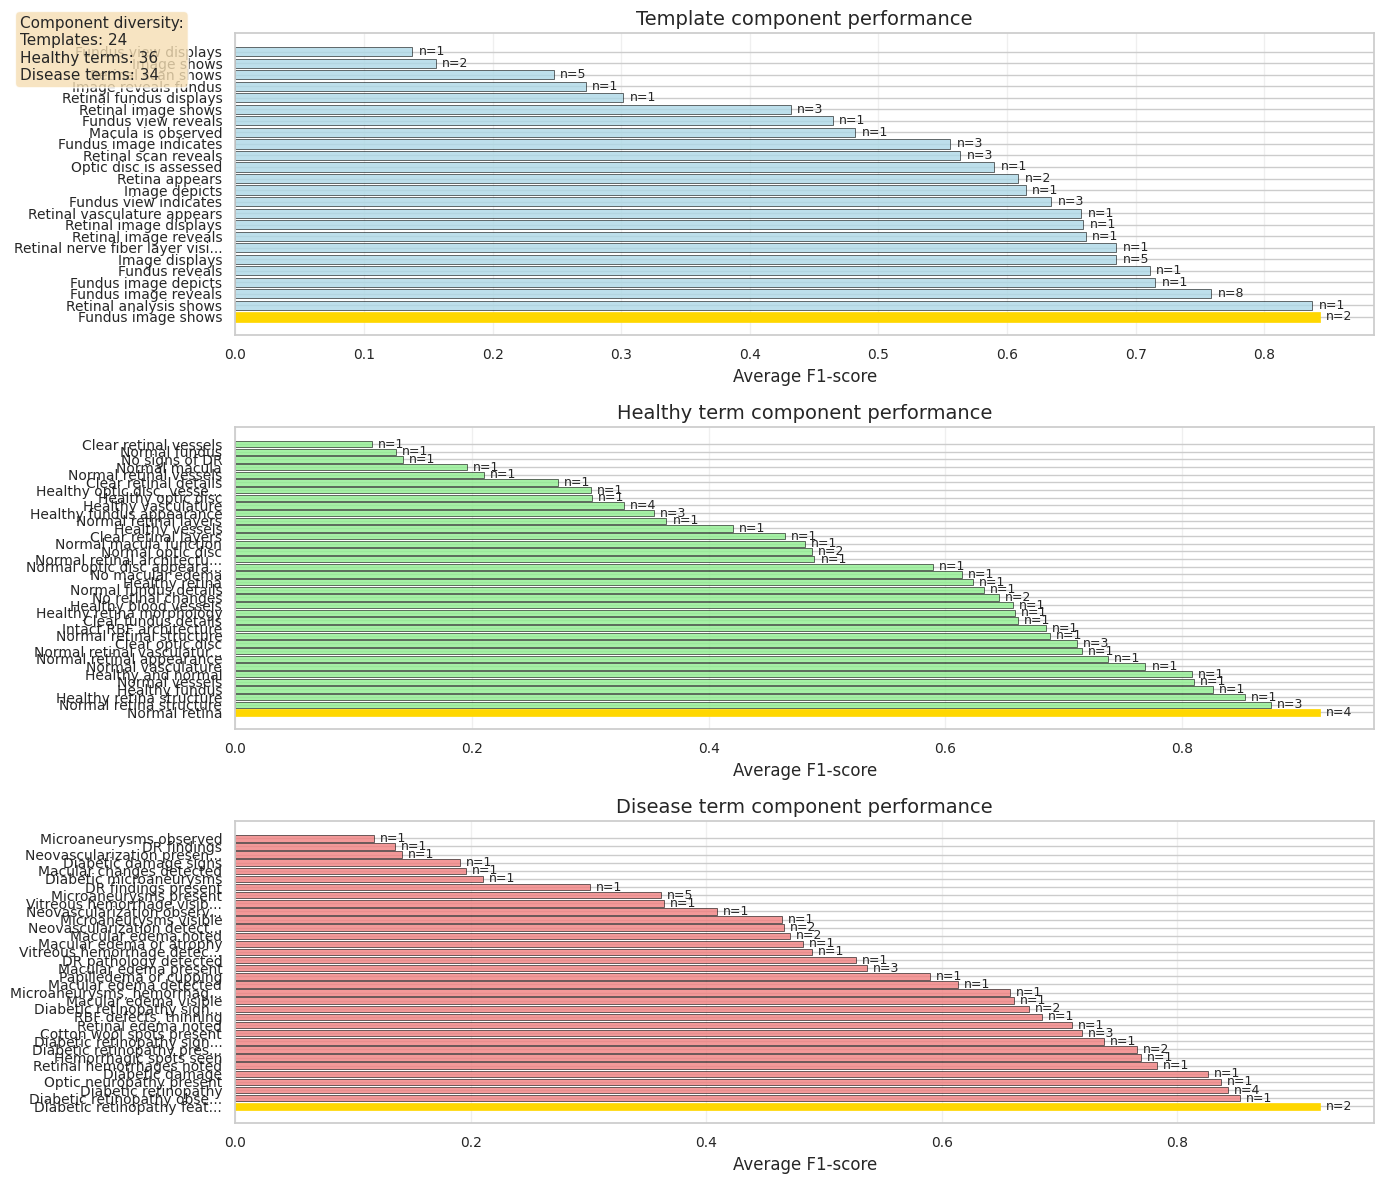

✅ All final extension plots created!

📁 Plots saved in: ./extension_plots/

Plot summary:

1. performance_analysis.pdf - Learning vs transfer across tasks

2. computational_efficiency.pdf - Efficiency comparison

3. learning_progression.pdf - Start vs final stages evolution

4. candidate_quality_distribution.pdf - Solution space exploration

5. search_space_exploration.pdf - Novel prompt landscape navigation

6. prompt_component_analysis.pdf - Breakdown of prompt components

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Create plots directory
os.makedirs('extension_plots', exist_ok=True)

# Set journal-quality style parameters
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})


def plot_prompt_component_analysis(best_values):
    """
    Plot 6: UNIQUE - Prompt component contribution analysis
    Novel visualization showing how different prompt components contribute to performance
    """
    if 'ape_tracking' not in best_values:
        print("❌ No tracking data available for prompt component analysis")
        return
    
    tracking_data = best_values['ape_tracking']
    all_candidates = tracking_data['all_candidates']
    
    if not all_candidates:
        print("❌ No candidate data available")
        return
    
    # Analyze component contributions
    template_performance = {}
    healthy_term_performance = {}
    disease_term_performance = {}
    
    for candidate in all_candidates:
        template = candidate['template'] if candidate['template'] else '(empty)'
        healthy = candidate['descriptions']['No retinopathy']
        disease = candidate['descriptions']['Retinopathy']
        f1 = candidate['f1']
        
        # Track performance by component
        if template not in template_performance:
            template_performance[template] = []
        template_performance[template].append(f1)
        
        if healthy not in healthy_term_performance:
            healthy_term_performance[healthy] = []
        healthy_term_performance[healthy].append(f1)
        
        if disease not in disease_term_performance:
            disease_term_performance[disease] = []
        disease_term_performance[disease].append(f1)
    
    # Calculate average performance for each component
    template_avg = {k: np.mean(v) for k, v in template_performance.items()}
    healthy_avg = {k: np.mean(v) for k, v in healthy_term_performance.items()}
    disease_avg = {k: np.mean(v) for k, v in disease_term_performance.items()}
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))
    
    # Plot 1: Template performance
    templates = list(template_avg.keys())
    template_scores = list(template_avg.values())
    template_counts = [len(template_performance[t]) for t in templates]
    
    # Sort by performance
    sorted_templates = sorted(zip(templates, template_scores, template_counts), 
                             key=lambda x: x[1], reverse=True)
    templates, template_scores, template_counts = zip(*sorted_templates)
    
    bars1 = ax1.barh(range(len(templates)), template_scores, 
                     color='lightblue', alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add count labels
    for i, (score, count) in enumerate(zip(template_scores, template_counts)):
        ax1.text(score + 0.005, i, f'n={count}', va='center', fontsize=9)
    
    ax1.set_yticks(range(len(templates)))
    ax1.set_yticklabels([t[:30] + '...' if len(t) > 30 else t for t in templates], fontsize=10)
    ax1.set_xlabel('Average F1-score')
    ax1.set_title('Template component performance')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Healthy term performance
    healthy_terms = list(healthy_avg.keys())
    healthy_scores = list(healthy_avg.values())
    healthy_counts = [len(healthy_term_performance[h]) for h in healthy_terms]
    
    # Sort by performance
    sorted_healthy = sorted(zip(healthy_terms, healthy_scores, healthy_counts), 
                           key=lambda x: x[1], reverse=True)
    healthy_terms, healthy_scores, healthy_counts = zip(*sorted_healthy)
    
    bars2 = ax2.barh(range(len(healthy_terms)), healthy_scores, 
                     color='lightgreen', alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add count labels
    for i, (score, count) in enumerate(zip(healthy_scores, healthy_counts)):
        ax2.text(score + 0.005, i, f'n={count}', va='center', fontsize=9)
    
    ax2.set_yticks(range(len(healthy_terms)))
    ax2.set_yticklabels([h[:25] + '...' if len(h) > 25 else h for h in healthy_terms], fontsize=10)
    ax2.set_xlabel('Average F1-score')
    ax2.set_title('Healthy term component performance')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Plot 3: Disease term performance
    disease_terms = list(disease_avg.keys())
    disease_scores = list(disease_avg.values())
    disease_counts = [len(disease_term_performance[d]) for d in disease_terms]
    
    # Sort by performance
    sorted_disease = sorted(zip(disease_terms, disease_scores, disease_counts), 
                           key=lambda x: x[1], reverse=True)
    disease_terms, disease_scores, disease_counts = zip(*sorted_disease)
    
    bars3 = ax3.barh(range(len(disease_terms)), disease_scores, 
                     color='lightcoral', alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add count labels
    for i, (score, count) in enumerate(zip(disease_scores, disease_counts)):
        ax3.text(score + 0.005, i, f'n={count}', va='center', fontsize=9)
    
    ax3.set_yticks(range(len(disease_terms)))
    ax3.set_yticklabels([d[:25] + '...' if len(d) > 25 else d for d in disease_terms], fontsize=10)
    ax3.set_xlabel('Average F1-score')
    ax3.set_title('Disease term component performance')
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Highlight best components
    for ax, bars in [(ax1, bars1), (ax2, bars2), (ax3, bars3)]:
        if bars:
            bars[0].set_color('#FFD700')  # Gold for best performer
            bars[0].set_alpha(1.0)
    
    # Add overall statistics
    total_templates = len(template_avg)
    total_healthy = len(healthy_avg)
    total_disease = len(disease_avg)
    
    stats_text = f"Component diversity:\nTemplates: {total_templates}\nHealthy terms: {total_healthy}\nDisease terms: {total_disease}"
    fig.text(0.02, 0.98, stats_text, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('extension_plots/prompt_component_analysis.pdf', dpi=300, bbox_inches='tight')
    plt.show()


def plot_comprehensive_performance_analysis(best_values):
    """
    Plot 1: Comprehensive performance analysis
    Combines task performance, learning vs transfer, and shows efficiency
    """
    # Extract data
    tasks = [k for k in best_values.keys() if isinstance(k, int)]
    ape_scores = [best_values[task]['best_score'] for task in tasks]
    
    # Get baseline scores
    if 'ape_tracking' in best_values:
        baseline_scores = best_values['ape_tracking']['summary'].get('baseline_scores', {})
        exhaustive_scores = []
        for task in tasks:
            if task == 0:
                exhaustive_scores.append(baseline_scores.get('exhaustive_search', 0.8921))
            else:
                exhaustive_scores.append(baseline_scores.get(f'exhaustive_task{task}', 0.89))
    else:
        exhaustive_scores = [0.8921, 0.8899, 0.8909][:len(tasks)]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot task-by-task comparison
    x = np.arange(len(tasks))
    width = 0.35
    
    # Color coding: learning task vs transfer tasks
    ape_colors = ['#228B22'] + ['#90EE90'] * (len(tasks) - 1)
    exhaustive_colors = ['#B22222'] + ['#FFA07A'] * (len(tasks) - 1)
    
    bars1 = ax.bar(x - width/2, ape_scores, width, label='APE', 
                   color=ape_colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x + width/2, exhaustive_scores, width, label='Exhaustive search', 
                   color=exhaustive_colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 2), textcoords="offset points", ha='center', va='bottom',
                    fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 2), textcoords="offset points", ha='center', va='bottom',
                    fontsize=9)
    
    # Add performance difference annotations
    for i, (ape_score, exhaustive_score) in enumerate(zip(ape_scores, exhaustive_scores)):
        diff = ape_score - exhaustive_score
        color = 'green' if diff > 0 else 'red'
        symbol = '+' if diff > 0 else ''
        ax.annotate(f'{symbol}{diff:.3f}', 
                   xy=(i, max(ape_score, exhaustive_score) + 0.015),
                   ha='center', va='bottom', fontweight='bold', color=color, fontsize=9)
    
    # Formatting
    ax.set_xlabel('Evolution iteration')
    ax.set_ylabel('F1-score')
    ax.set_title('Performance comparison: learning vs transfer across tasks')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{i}\n{"(Learning)" if i == 0 else "(Transfer)"}' for i in tasks])
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('extension_plots/performance_analysis.pdf', dpi=300, bbox_inches='tight')
    plt.show()

def plot_computational_efficiency(best_values):
    """
    Plot 2: Computational efficiency comparison
    Clean efficiency analysis showing evaluation count difference
    """
    # Get efficiency data
    if 'ape_tracking' in best_values:
        ape_evaluations = best_values['ape_tracking']['summary']['total_candidates']
    else:
        ape_evaluations = 25  # Fallback
    
    exhaustive_evaluations = 110
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Data
    methods = ['APE', 'Exhaustive search']
    evaluations = [ape_evaluations, exhaustive_evaluations]
    colors = ['#32CD32', '#FF6347']
    
    # Create bars
    bars = ax.bar(methods, evaluations, color=colors, alpha=0.8, 
                  edgecolor='black', linewidth=1, width=0.6)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom',
                    fontsize=12, fontweight='bold')
    
    # Add efficiency ratio (positioned to avoid overlap)
    efficiency_gain = exhaustive_evaluations / ape_evaluations
    ax.text(0.5, max(evaluations) * 0.5, f'{efficiency_gain:.1f}× more\nefficient', 
             ha='center', va='center', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='#FFFF99', alpha=0.9, 
                      edgecolor='black', linewidth=1))
    
    # Formatting
    ax.set_ylabel('Number of evaluations')
    ax.set_title('Computational efficiency comparison')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, max(evaluations) * 1.1)
    
    plt.tight_layout()
    plt.savefig('extension_plots/computational_efficiency.pdf', dpi=300, bbox_inches='tight')
    plt.show()

def plot_learning_progression(best_values):
    """
    Plot 3: Learning progression showing start vs final stages
    Inspired by "APE Autonomous Learning: Real Evolution Data"
    """
    if 'ape_tracking' not in best_values:
        print("❌ No tracking data available for learning progression")
        return
    
    tracking_data = best_values['ape_tracking']
    evolution_history = tracking_data['evolution_history']
    summary = tracking_data['summary']
    
    # Get start and end states
    start_state = evolution_history[0]
    end_state = evolution_history[-1]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Data for comparison
    stages = ['Start', 'Final']
    f1_scores = [start_state['f1'], end_state['f1']]
    colors = ['#FF6B6B', '#4ECDC4']
    
    # Create bars
    bars = ax.bar(stages, f1_scores, color=colors, alpha=0.8, 
                  edgecolor='black', linewidth=1, width=0.5)
    
    # Add F1 score labels
    for bar, f1 in zip(bars, f1_scores):
        height = bar.get_height()
        ax.annotate(f'F1: {height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                   xytext=(0, 3), textcoords="offset points", ha='center', va='bottom',
                   fontsize=12, fontweight='bold')
    
    # Add improvement box positioned between bars
    improvement = summary['total_improvement']
    ax.text(0.5, (f1_scores[0] + f1_scores[1])/2, f'Improvement\n+{improvement:.3f}\nin {summary["evolution_steps"]} steps', 
            ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8,
                     edgecolor='black', linewidth=1))
    
    # Add prompt descriptions below bars
    start_prompt = f"Template: '{start_state['template']}'\n" if start_state['template'] else "Template: (empty)\n"
    start_prompt += f"Healthy: '{start_state['descriptions']['No retinopathy']}'\n"
    start_prompt += f"Disease: '{start_state['descriptions']['Retinopathy']}'"
    
    end_prompt = f"Template: '{end_state['template']}'\n"
    end_prompt += f"Healthy: '{end_state['descriptions']['No retinopathy']}'\n"
    end_prompt += f"Disease: '{end_state['descriptions']['Retinopathy']}'"
    
    ax.text(0, -0.15, start_prompt, ha='center', va='top', fontsize=10,
           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7),
           transform=ax.get_xaxis_transform())
    
    ax.text(1, -0.15, end_prompt, ha='center', va='top', fontsize=10,
           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7),
           transform=ax.get_xaxis_transform())
    
    # Add statistics
    stats_text = f"Evolution time: {summary['total_time']:.1f}s\n"
    stats_text += f"Total candidates: {summary['total_candidates']}"
    # if summary.get('target_achieved'):
    #     stats_text += f"Target achieved: ✓"
    
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Formatting
    ax.set_ylabel('F1-score')
    ax.set_title('APE autonomous learning: from basic to optimal prompts')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, max(f1_scores) * 1.4)
    
    plt.tight_layout()
    plt.savefig('extension_plots/learning_progression.pdf', dpi=300, bbox_inches='tight')
    plt.show()

def plot_candidate_quality_distribution(best_values):
    """
    Plot 4: Candidate quality distribution (simplified and clearer)
    Shows how APE explores the solution space across iterations
    """
    if 'ape_tracking' not in best_values:
        print("❌ No tracking data available for candidate quality distribution")
        return
    
    tracking_data = best_values['ape_tracking']
    all_candidates = tracking_data['all_candidates']
    evolution_history = tracking_data['evolution_history']
    
    if not all_candidates:
        print("❌ No candidate data available")
        return
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare data for violin plot (better than box plot for this purpose)
    iterations = sorted(set(candidate['iteration'] for candidate in all_candidates))
    iteration_data = []
    iteration_labels = []
    
    for iteration in iterations:
        iter_candidates = [c for c in all_candidates if c['iteration'] == iteration]
        f1_scores = [c['f1'] for c in iter_candidates]
        iteration_data.append(f1_scores)
        iteration_labels.append(f'{iteration}')
    
    # Create violin plot
    parts = ax.violinplot(iteration_data, positions=range(len(iterations)), 
                         showmeans=True, showmedians=True)
    
    # Customize violin plot appearance
    for pc in parts['bodies']:
        pc.set_facecolor('#87CEEB')
        pc.set_alpha(0.7)
    
    # Highlight evolution trajectory
    selected_f1s = []
    selected_positions = []
    
    for i, iteration in enumerate(iterations):
        # Find if this iteration had a successful evolution
        for step in evolution_history[1:]:  # Skip starting point
            if step['iteration'] == iteration:
                selected_f1s.append(step['f1'])
                selected_positions.append(i)
                break
    
    # Plot selected candidates
    if selected_positions:
        ax.scatter(selected_positions, selected_f1s, c='#FFD700', s=100, marker='*', 
                  edgecolors='black', linewidth=1.5, label='Selected for evolution', zorder=5)
    
    # Add trend line for selected candidates
    if len(selected_positions) > 1:
        z = np.polyfit(selected_positions, selected_f1s, 1)
        p = np.poly1d(z)
        ax.plot(selected_positions, p(selected_positions), 'r--', alpha=0.8, 
               linewidth=2, label='Evolution trend')
    
    # Formatting
    ax.set_xlabel('Evolution iteration')
    ax.set_ylabel('F1-score distribution')
    ax.set_title('Candidate quality distribution across iterations')
    ax.set_xticks(range(len(iterations)))
    ax.set_xticklabels(iteration_labels)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('extension_plots/candidate_quality_distribution.pdf', dpi=300, bbox_inches='tight')
    plt.show()

def plot_search_space_exploration(best_values):
    """
    Plot 5: UNIQUE - Search space exploration analysis
    Novel visualization showing how APE navigates the prompt optimization landscape
    """
    if 'ape_tracking' not in best_values:
        print("❌ No tracking data available for search space exploration")
        return
    
    tracking_data = best_values['ape_tracking']
    all_candidates = tracking_data['all_candidates']
    evolution_history = tracking_data['evolution_history']
    
    if not all_candidates:
        print("❌ No candidate data available")
        return
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Extract unique templates and descriptions
    all_templates = set()
    all_healthy_terms = set()
    all_disease_terms = set()
    
    for candidate in all_candidates:
        all_templates.add(candidate['template'] if candidate['template'] else '(empty)')
        all_healthy_terms.add(candidate['descriptions']['No retinopathy'])
        all_disease_terms.add(candidate['descriptions']['Retinopathy'])
    
    # Create a 2D representation: x = template variety, y = description variety
    # This is a novel way to visualize prompt space exploration
    template_list = sorted(list(all_templates))
    description_pairs = set()
    
    for candidate in all_candidates:
        template = candidate['template'] if candidate['template'] else '(empty)'
        healthy = candidate['descriptions']['No retinopathy']
        disease = candidate['descriptions']['Retinopathy']
        description_pairs.add((healthy, disease))
    
    description_list = sorted(list(description_pairs))
    
    # Map candidates to 2D space
    x_coords = []
    y_coords = []
    f1_scores = []
    iterations = []
    is_selected = []
    
    for candidate in all_candidates:
        template = candidate['template'] if candidate['template'] else '(empty)'
        healthy = candidate['descriptions']['No retinopathy']
        disease = candidate['descriptions']['Retinopathy']
        desc_pair = (healthy, disease)
        
        x = template_list.index(template)
        y = description_list.index(desc_pair)
        
        x_coords.append(x)
        y_coords.append(y)
        f1_scores.append(candidate['f1'])
        iterations.append(candidate['iteration'])
        
        # Check if this candidate was selected for evolution
        selected = False
        for step in evolution_history[1:]:
            if (step['template'] == candidate['template'] and 
                step['descriptions'] == candidate['descriptions']):
                selected = True
                break
        is_selected.append(selected)
    
    # Create scatter plot with F1 scores as color
    scatter = ax.scatter(x_coords, y_coords, c=f1_scores, s=60, 
                        cmap='RdYlGn', alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Highlight selected candidates
    selected_x = [x for x, selected in zip(x_coords, is_selected) if selected]
    selected_y = [y for y, selected in zip(y_coords, is_selected) if selected]
    selected_f1 = [f1 for f1, selected in zip(f1_scores, is_selected) if selected]
    
    if selected_x:
        ax.scatter(selected_x, selected_y, s=200, marker='*', c='gold', 
                  edgecolors='black', linewidth=2, label='Selected for evolution', zorder=5)
        
        # Connect selected points to show evolution path
        if len(selected_x) > 1:
            ax.plot(selected_x, selected_y, 'r-', linewidth=2, alpha=0.8, 
                   label='Evolution path', zorder=4)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('F1-score')
    
    # Formatting
    ax.set_xlabel('Template variety')
    ax.set_ylabel('Description pair variety')
    ax.set_title('Search space exploration: APE navigation through prompt landscape')
    
    # Set tick labels (truncate if too many)
    max_labels = 8
    if len(template_list) > max_labels:
        step = len(template_list) // max_labels
        ax.set_xticks(range(0, len(template_list), step))
        ax.set_xticklabels([template_list[i][:15] + '...' if len(template_list[i]) > 15 
                           else template_list[i] for i in range(0, len(template_list), step)], 
                          rotation=45, ha='right')
    else:
        ax.set_xticks(range(len(template_list)))
        ax.set_xticklabels([t[:15] + '...' if len(t) > 15 else t for t in template_list], 
                          rotation=45, ha='right')
    
    if len(description_list) > max_labels:
        step = len(description_list) // max_labels
        ax.set_yticks(range(0, len(description_list), step))
        ax.set_yticklabels([f"{desc[0][:10]}...\nvs\n{desc[1][:10]}..." 
                           for desc in [description_list[i] for i in range(0, len(description_list), step)]], 
                          fontsize=8)
    else:
        ax.set_yticks(range(len(description_list)))
        ax.set_yticklabels([f"{desc[0][:10]}...\nvs\n{desc[1][:10]}..." 
                           for desc in description_list], fontsize=8)
    
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add exploration statistics
    exploration_text = f"Templates explored: {len(all_templates)}\n"
    exploration_text += f"Description pairs: {len(description_pairs)}\n"
    exploration_text += f"Total search points: {len(all_candidates)}\n"
    exploration_text += f"Successful selections: {sum(is_selected)}"
    
    ax.text(0.02, 0.98, exploration_text, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('extension_plots/search_space_exploration.pdf', dpi=300, bbox_inches='tight')
    plt.show()

def create_final_extension_plots(best_values):
    """
    Create all final extension plots for journal submission
    Five focused, unique plots that tell the complete APE story
    """
    print("🎨 Creating final extension plots for journal submission...")
    
    # Plot 1: Comprehensive performance analysis
    plot_comprehensive_performance_analysis(best_values)
    
    # Plot 2: Computational efficiency
    plot_computational_efficiency(best_values)
    
    # Plot 3: Learning progression (start vs final)
    plot_learning_progression(best_values)
    
    # Plot 4: Candidate quality distribution
    plot_candidate_quality_distribution(best_values)
    
    # Plot 5: Search space exploration (UNIQUE)
    plot_search_space_exploration(best_values)

    plot_prompt_component_analysis(best_values)
    
    print("✅ All final extension plots created!")
    print(f"📁 Plots saved in: ./extension_plots/")
    print("\nPlot summary:")
    print("  1. performance_analysis.pdf - Learning vs transfer across tasks")
    print("  2. computational_efficiency.pdf - Efficiency comparison")
    print("  3. learning_progression.pdf - Start vs final stages evolution")
    print("  4. candidate_quality_distribution.pdf - Solution space exploration")
    print("  5. search_space_exploration.pdf - Novel prompt landscape navigation")
    print("  6. prompt_component_analysis.pdf - Breakdown of prompt components")


create_final_extension_plots(best_values)

In [39]:
# # Initialize a plot
# sns.set(style="white", palette="pastel", font_scale=1.4)
# fig, ax = plt.subplots(figsize=(5, 4))

# # Get the best template name from the first entry in best_values
# best_template = best_values[0]['best_template']
# num_description_sets = len(description_sets_short) + len(description_sets_long)

# for task_index, task_accuracies in enumerate(task_all_accuracies):
#     # Get the f1-scores for the best template of this task
#     f1_scores = task_all_accuracies[task_index]['f1-score'][best_template]

#     # Create the x-axis values as a list of set numbers
#     sets = [f"Set {i+1}" for i in range(len(f1_scores))]

#     # Plot the f1-scores for this task
#     plt.plot(sets, f1_scores, label=f'Task {task_index}', marker='o')

# # Add labels and title
# plt.xlabel('Sets')
# plt.ylabel('F1-Score')
# plt.title('Best Template Over All Sets')
# # plt.yticks(fontsize=16)
# ax.set_xticks(np.arange(num_description_sets))
# ax.set_xticklabels([f" {i+1}" for i in range(num_description_sets)])
# # Add a legend if there are multiple tasks
# if len(task_all_accuracies) > 1:
#     plt.legend(prop={'size': 16})

# # Show the plot
# plt.savefig(f'best_template_tasks.pdf', bbox_inches='tight', pad_inches=0)
# plt.show()

In [40]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Initialize f1_matrix

# for task_index, task in enumerate(list_doclists):
#     all_f1_scores_ = task_all_accuracies[task_index]['f1-score']
#     num_templates = len(templates)
#     num_description_sets = len(description_sets_short) + len(description_sets_long)
#     f1_matrix = np.zeros((num_templates, num_description_sets))

#     # Fill in f1_matrix with the values from all_f1_scores
#     for i, template in enumerate(templates):
#         for j in range(num_description_sets):
#             f1_matrix[i, j] = all_f1_scores_[template][j]

#     # Plotting the F1-Score matrix
#     fig, ax = plt.subplots(figsize=(12, 12))

#     cax = ax.matshow(f1_matrix, cmap='coolwarm')

#     fig.colorbar(cax)

#     # Set up axes explicitly
#     ax.set_xticks(np.arange(num_description_sets))
#     ax.set_xticklabels([f"Set {i+1}" for i in range(num_description_sets)], 
#                        rotation=45, fontsize=16)
#     ax.set_yticks(np.arange(num_templates))
#     ax.set_yticklabels([t if t != '' else '[No template]' for t in templates])

#     # Loop over data dimensions and create text annotations.
#     for i in range(f1_matrix.shape[0]):
#         for j in range(f1_matrix.shape[1]):
#             ax.text(j, i, f"{f1_matrix[i, j]:.3f}", ha="center", va="center", color="w")

#     plt.xlabel('Description Sets', fontsize=18)
#     plt.ylabel('Templates', fontsize=18)
#     # plt.xticks(knns, fontsize=16)
#     plt.yticks(fontsize=16)
#     plt.title(f'F1-Scores for Task {task_index}', fontsize=20)
#     plt.savefig(f'ConfusionMatrix_{task_index}.pdf', bbox_inches='tight', pad_inches=0)

#     plt.show()


In [41]:
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns

# # Set the seaborn style and palette
# sns.set(style="white", palette="pastel", font_scale=1.1)

# # Number of top F1-score cells to plot
# top_n_cells = 3

# for task_index, task in enumerate(list_doclists):
#     all_f1_scores_ = task_all_accuracies[task_index]['f1-score']
#     num_templates = len(templates)
#     num_description_sets = len(description_sets_short) + len(description_sets_long)
#     f1_matrix = np.zeros((num_templates, num_description_sets))

#     # Fill in f1_matrix with the values from all_f1_scores
#     for i, template in enumerate(templates):
#         for j in range(num_description_sets):
#             f1_matrix[i, j] = all_f1_scores_[template][j]

#     # Find the top N highest F1-score cells
#     flat_indices = np.argsort(f1_matrix, axis=None)[-top_n_cells:]
#     top_f1_scores = np.unravel_index(flat_indices, f1_matrix.shape)

#     # Get the unique templates and description sets corresponding to the top F1-scores
#     unique_templates = np.unique(top_f1_scores[0])
#     unique_description_sets = np.unique(top_f1_scores[1])

#     # Reduce f1_matrix to include only the templates and description sets with top F1-scores
#     f1_matrix_reduced = f1_matrix[unique_templates, :][:, unique_description_sets]

#     # Plotting the reduced F1-Score matrix
#     fig, ax = plt.subplots(figsize=(3, 3))  # Reduced figure size

#     cax = ax.matshow(f1_matrix_reduced, cmap='coolwarm', aspect='auto')  # Adjust aspect ratio if needed

#     fig.colorbar(cax)

#     # Set up axes explicitly for the reduced matrix
#     ax.set_xticks(np.arange(len(unique_description_sets)))
#     ax.set_xticklabels([f"{i+1}" for i in unique_description_sets])

#     # Move the x-tick labels to the bottom and adjust position above the x label
#     ax.tick_params(axis='x', bottom=True, labelbottom=True, top=False, labeltop=False)
#     ax.xaxis.set_label_position('bottom')  # Move x label to bottom
#     ax.xaxis.set_ticks_position('bottom')  # Ensure ticks are also at the bottom

#     # Set the y-axis ticks
#     ax.set_yticks(np.arange(len(unique_templates)))
#     ax.set_yticklabels([str(i+1) for i in unique_templates])

#     # Loop over data dimensions and create text annotations for top F1-scores
#     for i in range(f1_matrix_reduced.shape[0]):
#         for j in range(f1_matrix_reduced.shape[1]):
#             ax.text(j, i, f"{f1_matrix_reduced[i, j]:.3f}", ha="center", va="center", color="w", fontsize=11)  # Adjust fontsize if needed

#     plt.xlabel('Top Description Sets')
#     plt.ylabel('Top Templates')
#     plt.title(f'Top {top_n_cells} F1-scores for Task {task_index}')
#     plt.savefig(f'TopF1Scores_{task_index}.pdf', bbox_inches='tight', pad_inches=0)

#     plt.show()


>>>> TASK = 0

image_embs: torch.Size([1040, 768])

text_emb: torch.Size([2, 768])

Estimated number of clusters: 2

Counter zero-shot labels = Counter({1: 712, 0: 328})

# Sampled docs (1.92%): 20

Accuracy: 0.921

f1_score: 0.923

/home/guess/mambaforge/envs/tadiler/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


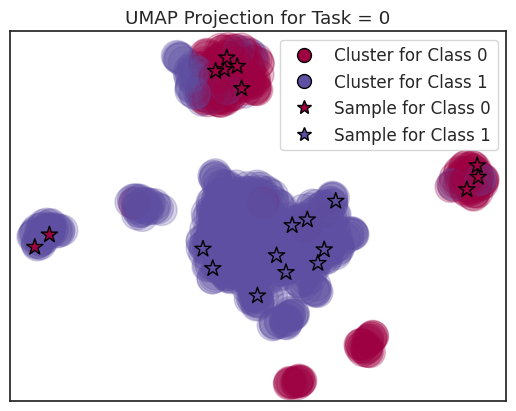

>>>> TASK = 1

image_embs: torch.Size([2622, 768])

text_emb: torch.Size([2, 768])

Estimated number of clusters: 2

Counter zero-shot labels = Counter({0: 1435, 1: 1187})

# Sampled docs (0.76%): 20

Accuracy: 0.917

f1_score: 0.917

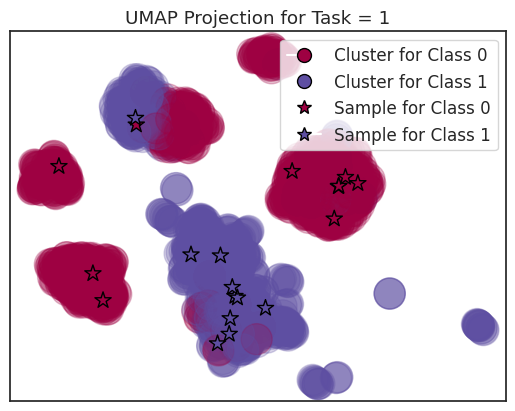

>>>> TASK = 2

image_embs: torch.Size([3662, 768])

text_emb: torch.Size([2, 768])

Estimated number of clusters: 2

Counter zero-shot labels = Counter({1: 1910, 0: 1752})

# Sampled docs (0.55%): 20

Accuracy: 0.918

f1_score: 0.918

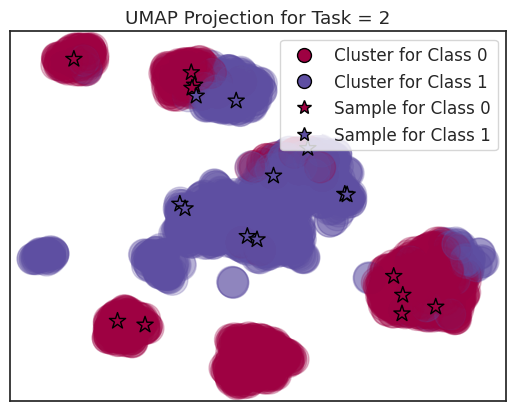

In [183]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from matplotlib.lines import Line2D
sns.set(style="white", palette="pastel", font_scale=1.1)
SEED = 42

# Initialize UMAP
umap_model = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.4, 
               metric='euclidean', learning_rate=0.5, dens_frac=1.0, random_state=SEED)

color_cluster_1 = (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)  # Replace with your actual color
color_cluster_2 = (0.3686274509803922, 0.30980392156862746, 0.6352941176470588, 1.0)   # Replace with your actual color

# Assuming you already have your multi-modal data and text embeddings
# cluster_legend_handle = Line2D([0], [0], marker='o', color='grey', label='Clusters',
#                                markersize=10, linestyle='None')

# sample_legend_handle = Line2D([0], [0], marker='*', color='grey', label='Samples',
#                               markersize=10, linestyle='None')
# cluster_legend_handle = Line2D([0], [0], marker='o', color='w', label='Clusters',
#                                markerfacecolor='none', markersize=10, markeredgewidth=1, markeredgecolor='black')
# sample_legend_handle = Line2D([0], [0], marker='*', color='w', label='Samples',
#                               markerfacecolor='none', markersize=10, markeredgewidth=1, markeredgecolor='black')
cluster_legend_handle_1 = Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color_cluster_1, markersize=10, 
                                 markeredgewidth=1, markeredgecolor='black', label='Cluster for Class 0')

cluster_legend_handle_2 = Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color_cluster_2, markersize=10, 
                                 markeredgewidth=1, markeredgecolor='black', label='Cluster for Class 1')

# Create two legend handles for the samples with marker '*'
sample_legend_handle_1 = Line2D([0], [0], marker='*', color='w', 
                                markerfacecolor=color_cluster_1, markersize=10, 
                                markeredgewidth=1, markeredgecolor='black', label='Sample for Class 0')

sample_legend_handle_2 = Line2D([0], [0], marker='*', color='w', 
                                markerfacecolor=color_cluster_2, markersize=10, 
                                markeredgewidth=1, markeredgecolor='black', label='Sample for Class 1')

for i, docs in enumerate(list_doclists):
    print(f">>>> TASK = {i}")
    clustered_docs, sampled_docs = get_zeroshot_sampling(docs, text_embs_best, labels_prompts_best, n_neighbors=10)
    ground_truth_labels = clustered_docs.label
    zeroshot_labels = clustered_docs.zeroshot_label

    print(f"Accuracy: {metrics.accuracy_score(ground_truth_labels, zeroshot_labels):.3f}")
    print(f"f1_score: {metrics.f1_score(ground_truth_labels, zeroshot_labels, average='weighted'):.3f}")  

    # Assume the embeddings are stored in a 'features' attribute
    docs_embeddings = torch.stack([data.embedding for data in clustered_docs]).detach().cpu().numpy()
    sampled_embeddings = torch.stack([doc.embedding for doc in sampled_docs]).detach().cpu().numpy()

    # Pre-compute 2D UMAP for visualization
    docs_embeddings_2d = umap_model.fit_transform(docs_embeddings)
    sampled_embeddings_2d = umap_model.transform(sampled_embeddings)  # You could save this and only load when needed

    # Define Colors
    cluster_colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, 2)]
    cluster_colors_ = [cluster_colors[i] for i in ground_truth_labels]
    sampled_colors_ = [cluster_colors[i] for i in sampled_docs.zeroshot_label]

    # Fast plotting
    plt.scatter(docs_embeddings_2d[:, 0], docs_embeddings_2d[:,  1], c=cluster_colors_, 
                marker='o', s=500, alpha=0.25, label=f'Clusters')
    
    plt.scatter(sampled_embeddings_2d[:, 0], sampled_embeddings_2d[:, 1], 
                c=sampled_colors_, marker='*', s=150, label=f'Samples', edgecolors="black")

    # plt.legend(scatterpoints=1, markerscale=0.7)
    plt.legend(handles=[cluster_legend_handle_1, cluster_legend_handle_2,
                    sample_legend_handle_1, sample_legend_handle_2])
    plt.title(f"UMAP Projection for Task = {i}")
    plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    plt.savefig(f'extension_plots/projection_task_{i}.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()


## TADILER: TADIL + Experience Replay 

In [184]:
random_indices = np.random.choice([10,20,30], 3, replace=False)
random_indices

array([20, 10, 30])

In [185]:
from avalanche.training.storage_policy import ParametricBuffer, _ParametricSingleBuffer
from avalanche.benchmarks.utils.data_loader import ReplayDataLoader
from avalanche.training.plugins import SupervisedPlugin
from avalanche.models import FeatureExtractorBackbone
from abc import ABC, abstractmethod
from torch import cat, Tensor
from typing import Dict, Optional, List

import numpy as np

class RandomExemplarsBuffer(ParametricBuffer):
    def __init__(self, max_size, n_neighbors=10, seed=42, groupby=None, 
                 selection_strategy=None):
        super().__init__(max_size, groupby, selection_strategy)
        self.n_neighbors = n_neighbors
        self.seed = seed
        print(">>>>RandomExemplarsBuffer2")

    def update(self, strategy, **kwargs):
        dataset_len = len(strategy.experience.dataset)
        if self.n_neighbors > dataset_len:
            raise ValueError("n_neighbors cannot be greater than the size of the dataset")
        
        np.random.seed(self.seed)
        random_indices = np.random.choice(dataset_len, self.n_neighbors, replace=False)
        
        # Get the input data (x_random) and task labels (t_random)
        x_random = [strategy.experience.dataset[i][0] for i in random_indices]
        t_random = [0 for i in random_indices]  # task labels
        # t_random = [strategy.experience.dataset[i][2] for i in random_indices]  # task labels
        
        x_random_pt = torch.stack(x_random).to(strategy.device)
        t_random_pt = torch.tensor(t_random).to(strategy.device)  # convert to tensor
        
        # Use the current model to predict labels for the randomly selected data
        strategy.model.eval()
        with torch.no_grad():
            # Pass both x_random_pt and task_labels (t_random_pt) to the model
            y_random_pt = strategy.model(x_random_pt, t_random_pt)
            y_random_pred = torch.argmax(y_random_pt, dim=1)  # Get predicted labels
        
        # Convert task labels and predicted labels to tensors
        y_random_pt = y_random_pred.cpu()  # Move to CPU
        t_random_pt = torch.from_numpy(np.asarray(t_random))

        # Create a new dataset using model-predicted labels instead of ground truth
        new_data = TensorDataset(x_random_pt.cpu(), y_random_pt, t_random_pt)
        new_data = AvalancheDataset(new_data)
        new_data.targets = y_random_pt.tolist()

        # Update the buffer with the new data
        print("Update x_random: ", len(x_random))
        print("Update y_random (predicted): ", len(y_random_pred))
        print("Update new_data: ", len(new_data))
        print("Update new_data[0]: ", len(new_data[0]))
        
        new_groups = self._make_groups(strategy, new_data)
        self.seen_groups.update(new_groups.keys())

        lens = self.get_group_lengths(len(self.seen_groups))
        group_to_len = {group_id: ll for group_id, ll in zip(self.seen_groups, lens)}

        for group_id, new_data_g in new_groups.items():
            ll = group_to_len[group_id]
            if group_id in self.buffer_groups:
                old_buffer_g = self.buffer_groups[group_id]
                old_buffer_g.update_from_dataset(strategy, new_data_g)
                old_buffer_g.resize(strategy, ll)
            else:
                new_buffer = _ParametricSingleBuffer(ll, self.selection_strategy)
                new_buffer.update_from_dataset(strategy, new_data_g)
                self.buffer_groups[group_id] = new_buffer

        for group_id, class_buf in self.buffer_groups.items():
            self.buffer_groups[group_id].resize(strategy, group_to_len[group_id])



class ZeroshotExemplarsBuffer(ParametricBuffer):
    def __init__(self, max_size, n_neighbors=10, groupby=None, 
                 selection_strategy=None):
        super().__init__(max_size, groupby, selection_strategy)
        self.n_neighbors = n_neighbors
        print(">>>>ZeroshotExemplarsBuffer")
        
    def update(self, strategy, **kwargs):
        data_list = list()
        for data in strategy.experience.dataset:
            data_list.append(MultiModal(embedding=data[0], path="", label=data[1], label_description="",
                                        zeroshot_label=-1, zeroshot_description="",
                                            task=data[2], task_description="",
                                            id_code="", metadata={}))
        multimodal_data = DocList[MultiModal](data_list)
        print(type(multimodal_data))
        clustered_docs, sampled_docs = get_zeroshot_sampling(multimodal_data, text_embs_best, labels_prompts_best, n_neighbors=self.n_neighbors)
        
        x_knn = sampled_docs.embedding
        y_knn = sampled_docs.zeroshot_label # we use zeroshot_label as the label, that is, we don't use the ground truth label

        t_knn = [0 for i in y_knn] # we dont use task labels for now, so we set it to 0
        
        x_knn_pt = torch.stack(x_knn)

        y_knn_pt = torch.from_numpy(np.asarray(y_knn))
        t_knn_pt = torch.from_numpy(np.asarray(t_knn))
        

        new_data = TensorDataset(x_knn_pt, y_knn_pt, t_knn_pt)
        new_data = AvalancheDataset(new_data)
        new_data.targets = y_knn_pt.tolist()
        # new_data = make_classification_dataset(new_data, task_labels=y_knn_pt)

        # print("@"*50)
        print("Update x_knn: ", len(x_knn))
        print("Update y_knn: ",  len(y_knn))
        print("Update new_data: ", len(new_data))
        print("Update new_data[0] before: ", len(new_data[0]))
        
        new_groups = self._make_groups(strategy, new_data)
        self.seen_groups.update(new_groups.keys())

        lens = self.get_group_lengths(len(self.seen_groups))
        group_to_len = {group_id: ll for group_id, ll in zip(self.seen_groups, lens)}

        for group_id, new_data_g in new_groups.items():
            ll = group_to_len[group_id]
            if group_id in self.buffer_groups:
                old_buffer_g = self.buffer_groups[group_id]
                old_buffer_g.update_from_dataset(strategy, new_data_g)
                old_buffer_g.resize(strategy, ll)
            else:
                new_buffer = _ParametricSingleBuffer(ll, self.selection_strategy)
                new_buffer.update_from_dataset(strategy, new_data_g)
                self.buffer_groups[group_id] = new_buffer

        for group_id, class_buf in self.buffer_groups.items():
            self.buffer_groups[group_id].resize(strategy, group_to_len[group_id])
        print("Update new_data[0] after: ", len(new_data[0]))


class FeatureExemplarsBuffer(ParametricBuffer):
    def __init__(self, max_size, model, layer_name, n_neighbors=10, groupby=None, selection_strategy=None):
        super().__init__(max_size, groupby, selection_strategy)
        self.feature_extractor = FeatureExtractorBackbone(model, layer_name)
        self.n_neighbors = n_neighbors  # Added n_neighbors parameter
        print(">>>>FeatureExemplarsBuffer initialized with n_neighbors =", n_neighbors)

    def update(self, strategy, **kwargs):
        # Step 1: Extract features for the current experience dataset
        data_list = list()
        for data in strategy.experience.dataset:
            data_list.append(MultiModal(embedding=data[0], path="", label=data[1], label_description="",
                                        zeroshot_label=-1, zeroshot_description="",
                                        task=data[2], task_description="",
                                        id_code="", metadata={}))

        multimodal_data = DocList[MultiModal](data_list)
        # Use the feature extractor to get feature embeddings
        features = self._extract_features(strategy, multimodal_data)

        # Step 2: Select the top n_neighbors exemplars based on feature importance
        sorted_indices = self._select_top_exemplars(features)

        # Limit to n_neighbors
        # print(f"Sorted indices: {sorted_indices}, type: {type(sorted_indices)}")
        def flatten(lst):
            """Flatten a nested list structure."""
            return [item for sublist in lst for item in (sublist if isinstance(sublist, list) else [sublist])]

        sorted_indices = flatten(sorted_indices)

        selected_indices = sorted_indices[:self.n_neighbors]  # Limit to n_neighbors exemplars

        # Step 3: Create new buffer data from selected exemplars
        x_selected = [strategy.experience.dataset[i][0] for i in selected_indices]
        y_selected = [strategy.experience.dataset[i][1] for i in selected_indices]
        t_selected = [0 for i in selected_indices]

        x_selected_pt = torch.stack(x_selected).to(strategy.device) 
        t_selected_pt = torch.tensor(t_selected).to(strategy.device) 


        strategy.model.eval()
        with torch.no_grad():
            # Pass both x_random_pt and task_labels (t_random_pt) to the model
            y_selected_pt = strategy.model(x_selected_pt, t_selected_pt)
            y_selected_pred = torch.argmax(y_selected_pt, dim=1)  # Get predicted labels


        # y_selected_pt = torch.from_numpy(np.asarray(y_selected))
        # t_selected_pt = torch.from_numpy(np.asarray(t_selected))

        new_data = TensorDataset(x_selected_pt.cpu(), y_selected_pred.cpu(), t_selected_pt.cpu())
        new_data = AvalancheDataset(new_data)
        new_data.targets = y_selected_pt.tolist()

        # Step 4: Update the buffer
        new_groups = self._make_groups(strategy, new_data)
        self.seen_groups.update(new_groups.keys())
        lens = self.get_group_lengths(len(self.seen_groups))
        group_to_len = {group_id: ll for group_id, ll in zip(self.seen_groups, lens)}

        for group_id, new_data_g in new_groups.items():
            ll = group_to_len[group_id]
            if group_id in self.buffer_groups:
                old_buffer_g = self.buffer_groups[group_id]
                old_buffer_g.update_from_dataset(strategy, new_data_g)
                old_buffer_g.resize(strategy, ll)
            else:
                new_buffer = _ParametricSingleBuffer(ll, self.selection_strategy)
                new_buffer.update_from_dataset(strategy, new_data_g)
                self.buffer_groups[group_id] = new_buffer

        for group_id, class_buf in self.buffer_groups.items():
            self.buffer_groups[group_id].resize(strategy, group_to_len[group_id])

    def _extract_features(self, strategy, multimodal_data):
        """Extract features from the multimodal data using the feature extractor."""
        self.feature_extractor.eval()
        features = []
        for doc in multimodal_data:
            feature = self.feature_extractor(doc.embedding.to(strategy.device))
            features.append(feature)

        # Stack features into a 2D tensor
        features = torch.stack(features, dim=0)  # Ensures 2D shape (batch_size, feature_dim)
        # print(f"Extracted Features shape: {features.shape}")  # Debugging output

        return features


    def _select_top_exemplars(self, features):
        """Select the top exemplars based on the sorted features."""
        sorted_indices = self.make_sorted_indices_from_features(features)
        return sorted_indices

    def make_sorted_indices_from_features(self, features: torch.Tensor) -> list:
        """Implementation to return sorted indices based on L2-norm of the features."""
        # print(f"Features shape: {features.shape}")  # Debugging statement

        # Ensure features is at least 2D, where each row is a separate example
        if features.dim() == 1:
            # Reshape to (1, feature_dim) if needed
            features = features.unsqueeze(0)

        # Now, compute the norm along the feature dimension (dim=1)
        norms = torch.norm(features, dim=1)
        
        # Debugging statement to check the norms
        # print(f"Norms shape: {norms.shape}, Norms: {norms}")
        
        # Sort the norms and get indices
        sorted_indices = torch.argsort(norms, descending=True)
        
        # Ensure sorted_indices is a list
        sorted_indices = sorted_indices.tolist() if torch.is_tensor(sorted_indices) else sorted_indices
        
        # Debugging statement to ensure sorted_indices is correct
        # print(f"Sorted indices (final): {sorted_indices}")
        
        return sorted_indices




class TADILER(SupervisedPlugin):
    def __init__(self, storage_policy):
        super().__init__()
        self.storage_policy = storage_policy
        # print("TADILER Wrapper")

    def before_training_exp(self, strategy,
                            num_workers: int = 0, shuffle: bool = False,
                            **kwargs):
        
        # print(dir(strategy))
        if len(self.storage_policy.buffer) == 0:
            return

        # print("@"*50)
        print(f"strategy.adapted_dataset: {len(strategy.adapted_dataset[0])}, Length: {len(strategy.adapted_dataset)}")
        print(f"self.storage_policy.buffer: {len(self.storage_policy.buffer[0])}, Length: {len(self.storage_policy.buffer)}")
        print(f"strategy.train_mb_size: {strategy.train_mb_size}")
        
        strategy.dataloader = ReplayDataLoader(
            strategy.adapted_dataset,
            self.storage_policy.buffer,
            # oversample_small_tasks=True,
            # task_balanced_dataloader=True,
            num_workers=num_workers,
            batch_size=strategy.train_mb_size,
            shuffle=shuffle)
        
    def after_training_exp(self, strategy, **kwargs):
        self.storage_policy.update(strategy)


### Train/Test split

In [186]:
from torch.utils.data import Dataset, DataLoader
from random import shuffle, seed

class CustomDataset(Dataset):
    """Dataset generator for the Custom dataset"""

    def __init__(self, docs: DocList[MultiModal], transform=None):
        self.docs = docs
        self.transform = transform
        self.targets = [doc.label for doc in self.docs]

    def __len__(self):
        """Returns the size of the dataset"""
        return len(self.docs)

    def __getitem__(self, idx):
        """Returns a batch of image, labels as Torch tensors"""
        image = self.docs[idx].embedding
        label = self.docs[idx].label

        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [187]:
from docarray import DocVec
DocVec[MultiModal]

docarray.array.any_array.DocVec[MultiModal]

In [188]:
from random import shuffle, seed

def split_datasets(docs: DocList[MultiModal], seed_val=123, train_percentage=0.8):

    shuffled_docs = list(docs)
    seed(seed_val)
    shuffle(shuffled_docs)
    shuffled_docs = DocList[MultiModal](shuffled_docs)

    split_idx = int(train_percentage * len(shuffled_docs))
    train_docs = shuffled_docs[:split_idx]
    test_docs = shuffled_docs[split_idx:]


    train_dataset = CustomDataset(train_docs)
    test_dataset = CustomDataset(test_docs)

    return train_dataset, test_dataset


In [189]:
import torch
from torch.utils.data import random_split

# Define the split sizes for each dataset
train_size = 0.8
SEED = 42


train_sets_method = []
test_sets_method = []
for doclist in list_doclists:

    train_dataset, test_dataset = split_datasets(doclist, seed_val=SEED, train_percentage=train_size)


    train_sets_method.append(train_dataset)
    test_sets_method.append(test_dataset)

print("#Method data")
print('Training lenghts: ', [len(ts) for ts in train_sets_method])
print('Testing lenghts: ', [len(ts) for ts in test_sets_method])


#Method data

Training lenghts: 
[832, 2097, 2929]

Testing lenghts: 
[208, 525, 733]

In [190]:
Counter(train_sets_method[1].docs.label_description)

Counter({'No retinopathy': 1223, 'Retinopathy': 874})

In [191]:
# %%time
from torch.utils.data.dataset import TensorDataset
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.utils import make_classification_dataset
from torch.utils.data import DataLoader
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark
from torch.utils.data import TensorDataset
    
# Method benchmark
training_datasets = list()
testing_datasets = list()

for task, (train_s, test_s) in enumerate(zip(train_sets_method, test_sets_method), start=0):

    training_datasets.append(make_classification_dataset(train_s, task_labels=train_s.docs.task))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=test_s.docs.task))

    
benchmark_method = dataset_benchmark(
    train_datasets=training_datasets,
    test_datasets=testing_datasets,
    # other_streams_datasets={'metadata': make_classification_dataset(dataset=[e.id_code for e in train_s], targets=[e.label for e in train_s])}
    # other_streams_datasets={'multimodal_train': make_classification_dataset(dataset=[e.id_code for e in train_s], targets=[e.label for e in train_s])}
)

In [192]:
# np.unique(downsampled_data['DR_ICDR'].values)

In [193]:
benchmark_method.task_labels

[[0], [1], [2]]

In [194]:
def get_sequence(sequence, stream):
    return [stream[i] for i in sequence]
sequence = [0, 1]
stream_seq = get_sequence(sequence, benchmark_method.train_stream)
stream_seq

In [195]:
# stream_seq[0].dataset[0][0]

In [196]:
# mt_model

In [197]:
# torch.all(stream_seq[0].dataset[0][0] == stream_seq[1].dataset[0][0])

## Prepare the strategies to run

In [198]:
from avalanche.training.supervised import Replay, GEM, LwF, EWC, Naive

def get_strategy(strategy_name, model, optimizer, criterion, eval_plugin, n_epochs, custom_replay):
    
    strategies = {
        'Naive': Naive( #Regularization-based method
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_mb_size=200,
            train_epochs=n_epochs,
            eval_mb_size=200,
            device=device,
            evaluator=eval_plugin,
            plugins=[custom_replay],
        ),
        'EWC': EWC( #Regularization-based method
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_mb_size=200,
            train_epochs=n_epochs,
            eval_mb_size=200,
            device=device,
            evaluator=eval_plugin,
            ewc_lambda=0.2,
            plugins=[custom_replay],
        ),
        'Replay': Replay( #Rehearsal-based method
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_mb_size=200,
            train_epochs=n_epochs,
            eval_mb_size=200,
            device=device,
            evaluator=eval_plugin,
            plugins=[custom_replay],
            mem_size=20,
        ),
        'LwF': LwF( #Architecture-based method
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            alpha=0.5,
            temperature=0.2,
            train_epochs=n_epochs,
            device=device,
            train_mb_size=200,
            eval_mb_size=200,
            evaluator=eval_plugin,
            plugins=[custom_replay],
        ),
        'GEM': GEM( #Architecture-based method
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            # alpha=0.5,
            # temperature=0.2,
            patterns_per_exp=10,
            train_epochs=n_epochs,
            device=device,
            train_mb_size=200,
            eval_mb_size=200,
            evaluator=eval_plugin,
            plugins=[custom_replay],
        ),

    }

    return strategies[strategy_name]

## Prepare and run the experiments

In [199]:
# root_exp_name = 'Agnostic_no_repetition_improver'
# root_exp_name = 'Agnostic_with_repetition'
# sequence = [0, 1, 2, 1, 3, 3, 4, 5]
sequence = list(range(len(benchmark_method.train_stream)))
print(f"Sequence = {sequence}")
n_epochs = 2


# list_n_neighbors = [15]
list_n_neighbors = [15, 20, 25, 30, 50, 100]

# random_seeds = [3]
random_seeds = [3,51, 35]
# random_seeds = [3,51, 35, 13, 25, 14, 100]
# random_seeds = [3, 11, 51, 1, 42, 35, 88, 100, 7, 13, 25, 14, 15, 16, 17, 18, 19, 20]

# 13, 3)-NAIVE | (25,51)-EWC | (100,14)-lwf | (35, 13
num_experiments = len(random_seeds)
print(f"n_exps = {num_experiments}")
# print(f"Setup = {root_exp_name}")
print(f"Epochs = {n_epochs}")
print(f"Seeds = {random_seeds}")
print(f"list n_neighbors = {list_n_neighbors}")

Sequence = [0, 1, 2]

n_exps = 3

Epochs = 2

Seeds = [3, 51, 35]

list n_neighbors = [15, 20, 25, 30, 50, 100]

In [200]:
benchmark_method.train_stream[0].dataset[0][0].device

device(type='cpu')

## NN architectures

In [201]:
import torch
import torch.nn as nn

def create_model(architecture_name, hidden_layer_size=256):
    n_inputs = 768  # Fixed input size
    n_outputs = 2   # Fixed output size (n_classes)

    class ResidualBlock(nn.Module):
        def __init__(self, in_features, out_features):
            super().__init__()
            self.linear1 = nn.Linear(in_features, out_features)
            self.linear2 = nn.Linear(out_features, out_features)
            self.relu = nn.ReLU()
            self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

        def forward(self, x):
            residual = x
            out = self.relu(self.linear1(x))
            out = self.linear2(out)
            out += self.shortcut(residual)
            return self.relu(out)
        

    class SelfAttention(nn.Module):
        def __init__(self, embed_size, heads):
            super().__init__()
            self.embed_size = embed_size
            self.heads = heads
            self.head_dim = embed_size // heads

            assert (
                self.head_dim * heads == embed_size
            ), "Embedding size needs to be divisible by number of heads"

            self.values = nn.Linear(embed_size, embed_size)
            self.keys = nn.Linear(embed_size, embed_size)
            self.queries = nn.Linear(embed_size, embed_size)
            self.fc_out = nn.Linear(embed_size, embed_size)

        def forward(self, x):
            # Handle 1D input by treating it as a batch of one sample
            if x.dim() == 1:
                x = x.unsqueeze(0).unsqueeze(1)  # Shape becomes (1, 1, embed_size)
            elif x.dim() == 2:
                x = x.unsqueeze(1)  # Shape becomes (batch_size, 1, embed_size)

            N, seq_len, embed_size = x.shape

            assert embed_size == self.embed_size, f"Expected embedding size {self.embed_size}, but got {embed_size}"

            values = self.values(x)
            keys = self.keys(x)
            queries = self.queries(x)

            # Reshape for multi-head attention
            values = values.view(N, seq_len, self.heads, self.head_dim).permute(0, 2, 1, 3)
            keys = keys.view(N, seq_len, self.heads, self.head_dim).permute(0, 2, 1, 3)
            queries = queries.view(N, seq_len, self.heads, self.head_dim).permute(0, 2, 1, 3)

            # Compute attention
            energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
            attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

            out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, seq_len, self.embed_size)

            return self.fc_out(out).squeeze(1)  # Remove the seq_len dimension if it's 1




    if architecture_name == "smlp":
        model = nn.Sequential(
            nn.Linear(n_inputs, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, n_outputs)
        )
    elif architecture_name == "residual":
        model = nn.Sequential(
            ResidualBlock(n_inputs, hidden_layer_size),
            ResidualBlock(hidden_layer_size, hidden_layer_size),
            ResidualBlock(hidden_layer_size, hidden_layer_size // 2),
            nn.Linear(hidden_layer_size // 2, n_outputs)
        )
    elif architecture_name == "attention":
        model = nn.Sequential(
            nn.Linear(n_inputs, hidden_layer_size),
            nn.ReLU(),
            SelfAttention(hidden_layer_size, 4),
            nn.Linear(hidden_layer_size, n_outputs)
        )
    else:
        raise ValueError(f"Unknown architecture name: {architecture_name}")

    return model

# Example usage:
model = create_model(architecture_name="attention")
# model = create_model(architecture_name="deep_mlp")
model
# mt_model = as_multitask(model, '-1')  # Use '-1' to refer to the last layer

Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): ReLU()
  (2): SelfAttention(
    (values): Linear(in_features=256, out_features=256, bias=True)
    (keys): Linear(in_features=256, out_features=256, bias=True)
    (queries): Linear(in_features=256, out_features=256, bias=True)
    (fc_out): Linear(in_features=256, out_features=256, bias=True)
  )
  (3): Linear(in_features=256, out_features=2, bias=True)
)

# Main

In [202]:
# %%time
import torch
import os
import copy
import random
# import wandb
import gc
from torch.nn import CrossEntropyLoss
import copy
import statistics as st
from torch.optim import Adam
from rich import print
from avalanche.models import as_multitask
from avalanche.benchmarks.classic import SplitMNIST, PermutedMNIST
from avalanche.models import MTSimpleMLP, MTSimpleCNN, SimpleCNN, SimpleMLP
# from avalanche.training.supervised import EWC, Naive, LFL
from avalanche.evaluation.metrics import (
    forgetting_metrics,
    accuracy_metrics,
    confusion_matrix_metrics
)
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger, WandBLogger
# from avalanche.training import Naive
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from avalanche.benchmarks.classic import SplitMNIST, PermutedMNIST, RotatedMNIST, SplitCIFAR10, SplitCIFAR100
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark
from avalanche.training.utils import adapt_classification_layer

from datetime import datetime
from avalanche.evaluation.metrics.images_samples import images_samples_metrics
from avalanche.evaluation.metrics.labels_repartition import (
    labels_repartition_metrics,
)
from avalanche.evaluation.metrics.mean_scores import mean_scores_metrics
from torch.nn import Linear


from torch.nn import Sequential, Linear, ReLU
import time
import pandas as pd

# Dictionary to store execution times
execution_times = {
    'Strategy': [],
    'Architecture': [],
    'SelectionStrategy': [],
    'ExecutionTime': []
}


for exp in range(num_experiments):

    for n_neighbors in list_n_neighbors:
        print(f"Length training: {len(benchmark_method.train_stream[0].dataset)}")
        print(f"Length testing: {len(benchmark_method.test_stream[0].dataset)}")

        print("-"*50)

        n_workers = 4
        # device = 'cpu'
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        seed = random_seeds[exp]
        random.seed(seed)
        torch.manual_seed(seed)

        print(f"Experiment: {exp+1} / {num_experiments}")
        print(f"Seed = {seed}")
        print(f"n_epochs = {n_epochs}")
        print(f"n_neighbors = {n_neighbors}")

        n_classes = len(np.unique(dl.label))
        embedding_shape = dl[0].embedding.shape[0]

        # all_strategies = ['EWC']
        all_strategies = ['Naive', 'GEM', 'LwF', 'EWC']
        


        for index_strat, strategy_name in enumerate(all_strategies):


            
            # list_architectures = ['smlp']
            list_architectures = ['attention', 'smlp', 'residual']
            # list_architectures = ['attention', 'residual']

            for architecture_name in list_architectures: 
                n_inputs = embedding_shape  # input size after CLIP embedding
                n_outputs = n_classes 
                hidden_layer_size = 256 

 

                model = create_model(architecture_name)


                layer_index = str(len(model)-1)
                mt_model = as_multitask(model, layer_index) 

                optimizer = Adam(mt_model.parameters(), lr=0.001)
                criterion = CrossEntropyLoss()
                # criterion = CrossEntropyLoss(weight=class_weights)


                selection_strategy_random = TADILER(RandomExemplarsBuffer(max_size=2000, groupby=None, 
                                                                n_neighbors=n_classes*n_neighbors))
                selection_strategy_tadiler = TADILER(ZeroshotExemplarsBuffer(max_size=2000, groupby=None, 
                                                                n_neighbors=n_neighbors))


                dict_selection_strategy = {'Random': selection_strategy_random, 
                                           'TADILER': selection_strategy_tadiler}
           
                for index_select, (name_selection, selection_strategy) in enumerate(dict_selection_strategy.items()):
                    benchmark_method_train_stream = get_sequence(sequence, benchmark_method.train_stream)
                    benchmark_method_test_stream = get_sequence(sequence, benchmark_method.test_stream)

                    loggers = []
    
                    loggers.append(InteractiveLogger())
                    # loggers.append(wandb_logger)

                    eval_plugin = EvaluationPlugin(
                        accuracy_metrics(
                            minibatch=False, epoch=False, experience=True
                        ),

                        forgetting_metrics(experience=True),
                        confusion_matrix_metrics(save_image=False, normalize=None, stream=True),
                        loggers=loggers,
                    )
                    

            
                    strategy = get_strategy(strategy_name, mt_model, optimizer, criterion, 
                                            eval_plugin, n_epochs, selection_strategy)

                    print(f"Running strategy: {strategy_name}-{name_selection}, experiment: {exp}, n_neighbors={n_neighbors}")

                    start_time = time.time()

                    results = {key: [] for key in ['values']}

                    folder_path = f'./extension_plots/results-{architecture_name}'
                    os.makedirs(folder_path, exist_ok=True)
                    if os.path.exists(f'{folder_path}/{strategy_name}-{name_selection}_knn_{n_neighbors}_seed_{seed}.pickle'):
                        continue
                        
                    # print(f"Sequence: {sequence}")
                    for index, (task, experience) in enumerate(zip(sequence, benchmark_method_train_stream)):

                        curr_experience = experience.current_experience

                        strategy.train(experience, num_workers=n_workers)
   

                        values = strategy.eval(benchmark_method_test_stream[:index+1], num_workers=n_workers)

                        if index == 0 and index_select == 0:
                            values_initial = values
                        elif index == 0 and index_select == 1:
                            values = values_initial

                        results['values'].append(values)

                        print("@"*60)
                        print()

                
                        
                    with open(f'{folder_path}/{strategy_name}-{name_selection}_knn_{n_neighbors}_seed_{seed}.pickle', 'wb') as handle:
                        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
                        print(f"Saved results for {strategy_name}_{name_selection}, seed: {seed}")


                    execution_time = time.time() - start_time
                    print(f"Execution time for {strategy_name}-{name_selection}: {execution_time:.2f} seconds")

                    # Store execution time in the dictionary
                    execution_times['Strategy'].append(strategy_name)
                    execution_times['Architecture'].append(architecture_name)
                    execution_times['SelectionStrategy'].append(name_selection)
                    execution_times['ExecutionTime'].append(execution_time)
                    
                    print("&"*100)
                    print()



        print("#"*100)


Length training: 832

Length testing: 208

--------------------------------------------------

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [90]:
execution_times_df = pd.DataFrame(execution_times)
execution_times_df.to_csv('extension_plots/execution_times.csv', index=False)
execution_times_df

# replace TADILER cells with "Ours"
execution_times_df['SelectionStrategy'] = execution_times_df['SelectionStrategy'].replace({'TADILER': 'Ours'})
# replace Random cells with Original
execution_times_df['SelectionStrategy'] = execution_times_df['SelectionStrategy'].replace({'Random': 'Original'})
execution_times_df['Architecture'] = execution_times_df['Architecture'].replace({'smlp': 'MLP', 'residual': 'Residual', 'attention': 'Attention'})

# divide execution times by 2
execution_times_df['ExecutionTime'] = execution_times_df['ExecutionTime'] / 3

# 
execution_times_df

,Strategy,Architecture,SelectionStrategy,ExecutionTime
0,Naive,Attention,Original,4.313833
1,Naive,Attention,Ours,4.414598
2,Naive,MLP,Original,4.160537
3,Naive,MLP,Ours,4.056929
4,Naive,Residual,Original,4.222126
5,Naive,Residual,Ours,4.450075
6,GEM,Attention,Original,4.793467
7,GEM,Attention,Ours,5.004701
8,GEM,MLP,Original,5.024907
9,GEM,MLP,Ours,5.820633


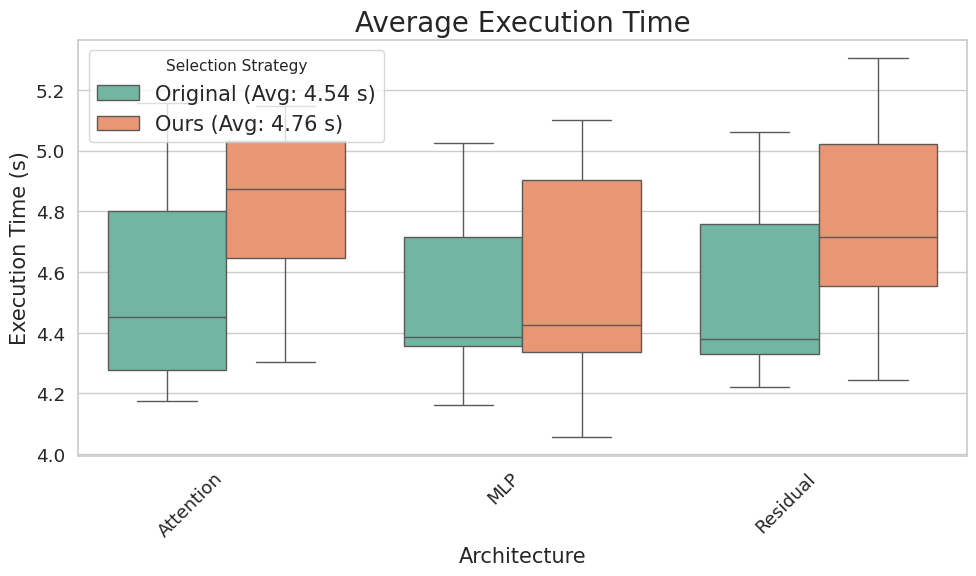

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from the "ExecutionTime" column
execution_times_df_filtered = remove_outliers(execution_times_df, 'ExecutionTime')

# Calculate the average execution time for each selection strategy
avg_times = execution_times_df_filtered.groupby('SelectionStrategy')['ExecutionTime'].mean()

# Set style for the plot
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

# Create a figure and axes for the plot
plt.figure(figsize=(10, 6))

# Create a box plot without outliers
ax = sns.boxplot(
    x="Architecture", 
    y="ExecutionTime", 
    hue="SelectionStrategy", 
    data=execution_times_df_filtered, 
    palette="Set2", 
    showfliers=False  # This ensures no outliers are shown in the plot
)

# Set plot labels and title
ax.set_xlabel("Architecture", fontsize=15)
ax.set_ylabel("Execution Time (s)", fontsize=15)
ax.set_title("Average Execution Time", fontsize=20)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=13)

# Update the legend with average times
handles, labels = ax.get_legend_handles_labels()
new_labels = [
    f"{label} (Avg: {avg_times[label]:.2f} s)" 
    for label in labels
]
ax.legend(handles=handles, labels=new_labels, title="Selection Strategy", title_fontsize='11', fontsize='15', loc='upper left')

# Show the plot
plt.tight_layout()
plt.savefig(f'./extension_plots/tadiler_execution_time.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


In [102]:
# 18m 41s FeatureBased
# 12m 6s TADILER
# 11m 16s Random

In [92]:
print(f"List of n_neighbors: {list_n_neighbors}")
print(f"Seeds: {random_seeds}")
print(f"Strategies: {all_strategies}")

List of n_neighbors: [15, 20, 25, 30, 50, 100]

Seeds: [3, 51, 35, 13, 25, 14, 100]

Strategies: ['Naive', 'GEM', 'LwF', 'EWC']

In [44]:
folder_path

'./results-smlp'

In [13]:
folder_path = './extension_plots/results-residual'
folder_path

'./extension_plots/results-residual'

In [3]:
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

from rich import print

global_avg_acc = dict() # Final Table
# s_name = "*"
s_name = "LwF"
# n_neighbors = "*"
n_neighbors = 15
seed = "*"
# seed = 100 #*
# 51, 42, 7
files = glob.glob(f"{folder_path}/{s_name}-*_*knn_{n_neighbors}_seed_{seed}.pickle")
# files = glob.glob(f"./results/{root_exp_name}*_*knn_{n_neighbors}_seed_{seed}.pickle")
print(files)

[
    './extension_plots/results-residual/LwF-Random_knn_15_seed_13.pickle',
    './extension_plots/results-residual/LwF-Random_knn_15_seed_25.pickle',
    './extension_plots/results-residual/LwF-Random_knn_15_seed_100.pickle',
    './extension_plots/results-residual/LwF-Random_knn_15_seed_35.pickle',
    './extension_plots/results-residual/LwF-TADILER_knn_15_seed_35.pickle',
    './extension_plots/results-residual/LwF-TADILER_knn_15_seed_3.pickle',
    './extension_plots/results-residual/LwF-Random_knn_15_seed_51.pickle',
    './extension_plots/results-residual/LwF-TADILER_knn_15_seed_25.pickle',
    './extension_plots/results-residual/LwF-TADILER_knn_15_seed_13.pickle',
    './extension_plots/results-residual/LwF-Random_knn_15_seed_14.pickle',
    './extension_plots/results-residual/LwF-TADILER_knn_15_seed_14.pickle',
    './extension_plots/results-residual/LwF-TADILER_knn_15_seed_100.pickle',
    './extension_plots/results-residual/LwF-Random_knn_15_seed_3.pickle',
    './extension_plots/results-residual/LwF-TADILER_knn_15_seed_51.pickle'
]

Method: plots/results-residual/LwF-Random | Values: [0.88232601 0.94908254 0.96208498]

Method: plots/results-residual/LwF-TADILER | Values: [0.88232601 0.97231472 0.97621148]

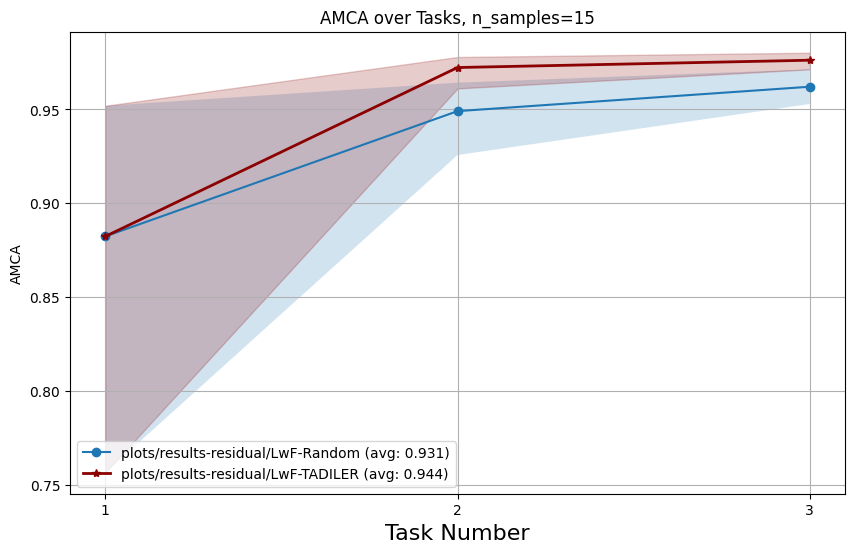

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle


def amca_from_confusion_matrix(confusion_matrix):
    # Average Mean Class Accuracy (AMCA)
    # Convert tensor to numpy array
    confusion_matrix = confusion_matrix.numpy()
    # Calculate per-class accuracy (diagonal elements / sum of row elements)
    class_accuracies = np.diagonal(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    # Return the average of class accuracies
    return np.nanmean(class_accuracies)

def weighted_f1_from_confusion_matrix(confusion_matrix):
    # Convert tensor to numpy array if it's a tensor
    if hasattr(confusion_matrix, 'numpy'):
        confusion_matrix = confusion_matrix.numpy()
    
    # Calculate precision for each class: TP / (TP + FP)
    # TP is the diagonal element and FP is the sum of column excluding the diagonal
    precision = np.diagonal(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    
    # Calculate recall for each class: TP / (TP + FN)
    # TP is the diagonal element and FN is the sum of row excluding the diagonal
    recall = np.diagonal(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    
    # Calculate F1-score for each class: 2 * (precision * recall) / (precision + recall)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    
    # Calculate the weighted F1-score
    weights = np.sum(confusion_matrix, axis=1) / np.sum(confusion_matrix)
    weighted_f1 = np.nansum(f1_scores * weights)
    
    return weighted_f1

data_dict = {}

for f in files:
    # Get the method and seed from the filename
    method_seed = f.split('_')[-5:]
    method = method_seed[0]
    seed = method_seed[4].split('.')[0]
    knn = method_seed[2]

    # Load the results
    with open(f, 'rb') as handle:
        r = pickle.load(handle)

    data = r['values']
    performances = []

    for i in range(len(data)):
        # Calculate the AMCA of the current task
        current_task_performance = amca_from_confusion_matrix(data[i]['ConfusionMatrix_Stream/eval_phase/test_stream'])
        performances.append(current_task_performance)

    # If the method is not in the dictionary, add it
    if method not in data_dict:
        data_dict[method] = {}

    # Add the performances to the data dictionary
    data_dict[method][seed] = performances

plt.figure(figsize=(10, 6))

for method, seeds in data_dict.items():
    # Get all the performances for this method
    all_performances = np.array(list(seeds.values()))

    # Calculate the mean, min, and max performances for each task
    mean_performances = np.mean(all_performances, axis=0)
    print(f'Method: {method} | Values: {mean_performances}')
    min_performances = np.min(all_performances, axis=0)
    max_performances = np.max(all_performances, axis=0)

    # Calculate overall average performance
    overall_avg_performance = np.mean(mean_performances)

    # Generate task numbers
    tasks = range(1, len(mean_performances) + 1)

    # Plot the mean performances and fill between the min and max performances
    if 'TADILER' in method:
        plt.plot(tasks, mean_performances, marker='*', linestyle='-', color='#8B0000',
                 label=f'{method} (avg: {overall_avg_performance:.3f})', linewidth=2)
        plt.fill_between(tasks, min_performances, max_performances, color='#8B0000', alpha=0.2)
    else:
        plt.plot(tasks, mean_performances, marker='o', linestyle='-',
                 label=f'{method} (avg: {overall_avg_performance:.3f})')
        plt.fill_between(tasks, min_performances, max_performances, alpha=0.2)
    # plt.fill_between(tasks, min_performances, max_performances, alpha=0.2)

plt.xlabel('Task Number', fontsize=16)
plt.ylabel('AMCA')
plt.title(f'AMCA over Tasks, n_samples={knn}')
plt.grid(True)
plt.xticks(tasks)
plt.legend()

plt.show()


In [113]:
folder_path

'./extension_plots/results-smlp'

'attention'

In [25]:
folder_path = './extension_plots/results-smlp'

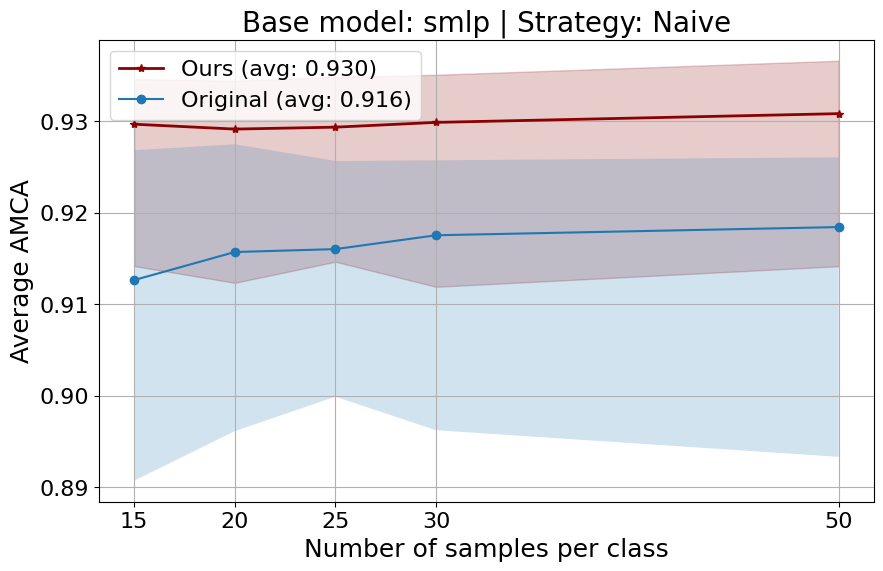

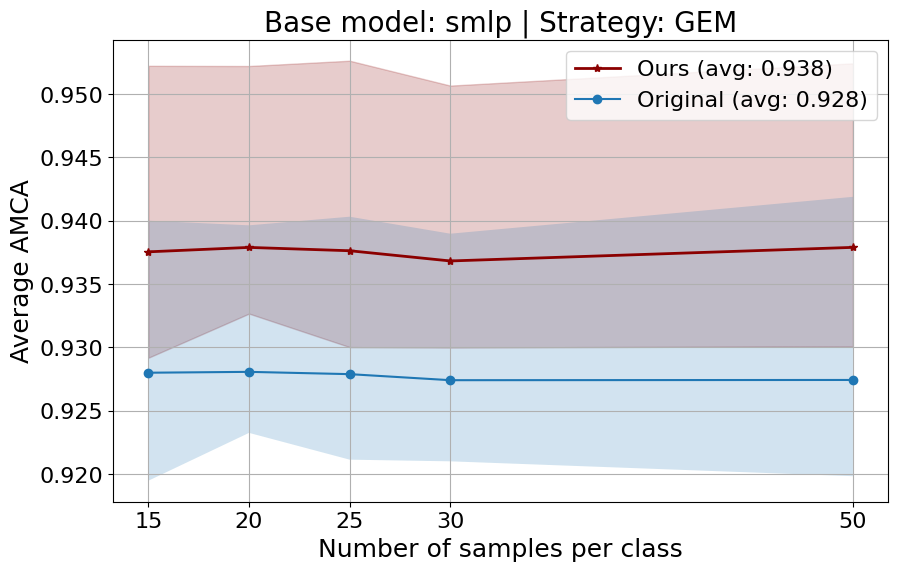

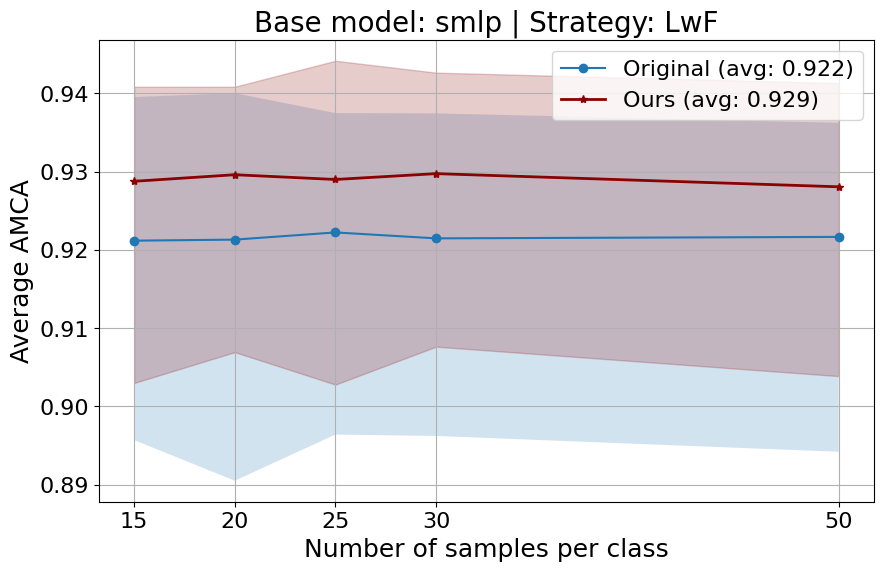

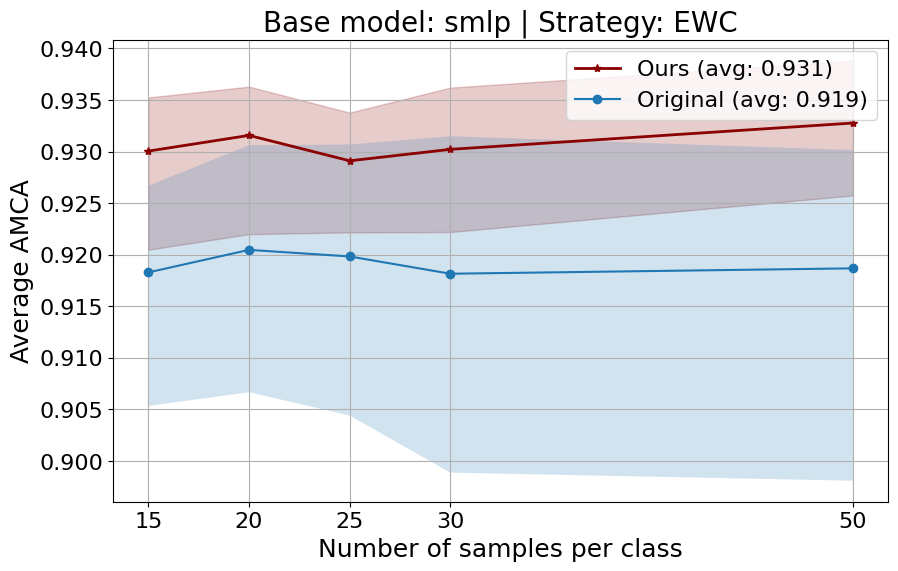

In [26]:
global_avg_acc = dict()  # Final Table
all_strategies = ['Naive', 'GEM', 'LwF', 'EWC']
df_data = []

for strategy_name in all_strategies:
    n_neighbors = "*"
    seed = "*"
    
    files = glob.glob(f"{folder_path}/{strategy_name}-*_*knn_{n_neighbors}_seed_{seed}.pickle")
    # files = [f for f in files if "seed_3." in f]
    files = [f for f in files if "_100_" not in f]
    
    data_dict = {}

    for f in files:
        method_seed = f.split('_')[-5:]
        model_name = method_seed[0].split("/")[1].split('-')[1]
        method = method_seed[0].split("/")[2]
        seed = method_seed[4].split('.')[0]
        knn = int(method_seed[2])

        # Load the results
        with open(f, 'rb') as handle:
            r = pickle.load(handle)

        data = r['values']
        
        # Extract AMCA and Forgetting for each experience
        task_amcas = [amca_from_confusion_matrix(d['ConfusionMatrix_Stream/eval_phase/test_stream']) for d in data]
        task_forgettings = []
        for d in data:
            for key in d.keys():
                if key.startswith('ExperienceForgetting/eval_phase/test_stream/Task'):
                    task_forgettings.append(d[key])
        
        # Compute the average forgetting for this specific combination
        if task_forgettings:
            overall_forgetting = np.mean(task_forgettings)
        else:
            overall_forgetting = None  # If no forgetting values, assign None

        # Ensure method exists in the dictionary
        if method not in data_dict:
            data_dict[method] = {}
        
        # Store AMCA and Forgetting for this knn value
        if knn not in data_dict[method]:
            data_dict[method][knn] = {'amcas': [], 'forgettings': []}
        
        # Append AMCA and Forgetting for each file
        data_dict[method][knn]['amcas'].append(np.mean(task_amcas))
        data_dict[method][knn]['forgettings'].append(overall_forgetting)

    # Plot results
    plt.figure(figsize=(10, 6))

    for method, knn_values in data_dict.items():
        method = method.replace("Random", "Original")
        knns = sorted(list(knn_values.keys()))
        
        means = [np.mean(knn_values[knn]['amcas']) for knn in knns]
        mins = [np.min(knn_values[knn]['amcas']) for knn in knns]
        maxs = [np.max(knn_values[knn]['amcas']) for knn in knns]
        forgettings = [np.mean(knn_values[knn]['forgettings']) for knn in knns]

        overall_avg_amca = np.mean(means)  # Average AMCA over all n_neighbors
        
        if 'TADILER' in method:
            plt.plot(knns, means, marker='*', linestyle='-', color='#8B0000', 
                     label=f"Ours (avg: {overall_avg_amca:.3f})", linewidth=2)
            plt.fill_between(knns, mins, maxs, color='#8B0000', alpha=0.2)
        else:
            plt.plot(knns, means, marker='o', linestyle='-', 
                     label=f"{method.split('-')[1]} (avg: {overall_avg_amca:.3f})")
            plt.fill_between(knns, mins, maxs, alpha=0.2)

    plt.xlabel('Number of samples per class', fontsize=18)
    plt.ylabel('Average AMCA', fontsize=18)
    plt.title(f'Base model: {model_name} | Strategy: {strategy_name}', fontsize=20)
    plt.grid(True)
    plt.xticks(knns, fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(prop={'size': 16})
    plt.show()

    # Collect data for DataFrame
    for method, knn_values in data_dict.items():
        knns = sorted(list(knn_values.keys()))
        means = [np.mean(knn_values[knn]['amcas']) for knn in knns]
        forgettings = [np.mean(knn_values[knn]['forgettings']) for knn in knns]

        for idx, knn in enumerate(knns):
            df_data.append({
                'Strategy': strategy_name,
                'Method': method,
                'KNN': knn,
                'Mean AMCA': means[idx],
                'Forgetting': forgettings[idx]  # Store Forgetting for each knn
            })


## find maximum

In [27]:
folder_path = './extension_plots/results-smlp'
folder_path

'./extension_plots/results-smlp'

In [28]:
import pandas as pd
import numpy as np
import glob
import pickle
from collections import defaultdict

# Define all seeds to process
all_seeds = [3, 51, 35, 13, 25, 14, 100]
all_strategies = ['Naive', 'GEM', 'LwF', 'EWC']
target_knns = [15, 20, 25, 30, 50]

def process_all_seeds_data(folder_path):
    """Process data for all seeds and return structured results"""
    all_results = []
    
    for seed in all_seeds:
        print(f"Processing seed {seed}...")
        
        for strategy_name in all_strategies:
            n_neighbors = "*"
            
            # Get files for this specific seed
            files = glob.glob(f"{folder_path}/{strategy_name}-*_*knn_{n_neighbors}_seed_{seed}.pickle")
            files = [f for f in files if "_100_" not in f and f"seed_{seed}." in f]
            
            for f in files:
                # Extract architecture from folder name (e.g., 'results-residual' -> 'residual')
                folder_name = f.split('/')[-2]  # Get the folder name
                architecture = folder_name.split('-')[-1]  # Get the part after 'results-'
                
                # Extract method from filename (e.g., 'LwF-Random' -> 'Random')
                filename = f.split('/')[-1]  # Get just the filename
                method = filename.split('_')[0].split('-')[1]  # Extract method part
                
                # Extract other info
                parts = f.split('_')
                current_seed = parts[-1].split('.')[0]  # seed from 'seed_13.pickle'
                knn = int(parts[-3])  # knn from 'knn_15'
                
                # Only process target KNN values
                if knn not in target_knns:
                    continue
                
                # Load the results
                with open(f, 'rb') as handle:
                    r = pickle.load(handle)
                data = r['values']
                
                # Extract AMCA and Forgetting for each experience
                task_amcas = [amca_from_confusion_matrix(d['ConfusionMatrix_Stream/eval_phase/test_stream']) for d in data]
                task_forgettings = []
                for d in data:
                    for key in d.keys():
                        if key.startswith('ExperienceForgetting/eval_phase/test_stream/Task'):
                            task_forgettings.append(d[key])
                
                # Compute the average forgetting for this specific combination
                if task_forgettings:
                    overall_forgetting = np.mean(task_forgettings)
                else:
                    overall_forgetting = None
                
                # Store results
                mean_amca = np.mean(task_amcas)
                
                all_results.append({
                    'Seed': int(current_seed),
                    'Strategy': strategy_name,
                    'Method': f"{strategy_name}-{method}",  # Combine strategy and method
                    'KNN': knn,
                    'AMCA': mean_amca,
                    'Forgetting': overall_forgetting,
                    'Model': architecture.title()  # Use architecture from folder name
                })
    
    return pd.DataFrame(all_results)

# Process all data
print("Processing all seeds and strategies...")
df_all = process_all_seeds_data(folder_path)

# Find the best seed for each Strategy, Method, KNN combination
print("Finding best performance for each Strategy-Method-KNN combination...")

df_max_data = []

# Group by Strategy, Method, KNN and find the seed with maximum AMCA
grouped = df_all.groupby(['Strategy', 'Method', 'KNN'])

for (strategy, method, knn), group in grouped:
    # Find the row with maximum AMCA for this combination
    max_idx = group['AMCA'].idxmax()
    best_result = group.loc[max_idx]
    
    # Rename method names as requested (method already contains strategy prefix)
    display_method = best_result['Method'].replace('TADILER', 'APE').replace('Random', 'Original')
    
    df_max_data.append({
        'Strategy': strategy,
        'Method': display_method,
        'KNN': knn,
        'Mean AMCA': best_result['AMCA'],
        'Forgetting': best_result['Forgetting'],
        'Architecture': best_result['Model'].upper() if best_result['Model'] == 'smlp' else best_result['Model'].title(),
        'Best_Seed': best_result['Seed']  # Keep track of which seed was best
    })

# Create the final DataFrame
df_max = pd.DataFrame(df_max_data)

# Sort by Strategy, Method, KNN for better readability
df_max = df_max.sort_values(['Strategy', 'Method', 'KNN']).reset_index(drop=True)

# Display results
print("\n" + "="*80)
print("MAXIMUM PERFORMANCE FOR EACH STRATEGY-METHOD-KNN COMBINATION")
print("="*80)
print(df_max)

# Verify we have all expected KNN values for each Strategy-Method combination
print("\n" + "="*80)
print("VERIFICATION: KNN Coverage")
print("="*80)

coverage_check = df_max.groupby(['Strategy', 'Method'])['KNN'].apply(lambda x: sorted(x.tolist())).reset_index()
coverage_check.columns = ['Strategy', 'Method', 'Available_KNNs']
print(coverage_check)

# Check for missing KNN values
expected_knns = set(target_knns)
for idx, row in coverage_check.iterrows():
    available_knns = set(row['Available_KNNs'])
    missing_knns = expected_knns - available_knns
    if missing_knns:
        print(f"WARNING: {row['Strategy']}-{row['Method']} is missing KNN values: {sorted(missing_knns)}")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

# Compare APE vs Original methods
ape_results = df_max[df_max['Method'].str.contains('APE')]
original_results = df_max[df_max['Method'].str.contains('Original')]

print(f"Total APE method results: {len(ape_results)}")
print(f"Total Original method results: {len(original_results)}")

if len(ape_results) > 0:
    print(f"APE methods - Mean AMCA: {ape_results['Mean AMCA'].mean():.6f} ± {ape_results['Mean AMCA'].std():.6f}")
    print(f"APE methods - Best AMCA: {ape_results['Mean AMCA'].max():.6f}")

if len(original_results) > 0:
    print(f"Original methods - Mean AMCA: {original_results['Mean AMCA'].mean():.6f} ± {original_results['Mean AMCA'].std():.6f}")
    print(f"Original methods - Best AMCA: {original_results['Mean AMCA'].max():.6f}")

# Show comparison for each strategy
print("\n" + "="*40)
print("STRATEGY-WISE COMPARISON")
print("="*40)

for strategy in all_strategies:
    strategy_ape = df_max[(df_max['Strategy'] == strategy) & (df_max['Method'].str.contains('APE'))]
    strategy_orig = df_max[(df_max['Strategy'] == strategy) & (df_max['Method'].str.contains('Original'))]
    
    if len(strategy_ape) > 0 and len(strategy_orig) > 0:
        ape_mean = strategy_ape['Mean AMCA'].mean()
        orig_mean = strategy_orig['Mean AMCA'].mean()
        improvement = ape_mean - orig_mean
        
        print(f"{strategy}: APE={ape_mean:.6f}, Original={orig_mean:.6f}, "
              f"Improvement={improvement:.6f} ({improvement*100:.3f}%)")
    else:
        print(f"{strategy}: Insufficient data for comparison")

# Clean up the final dataframe (remove the helper column)
df_max_final = df_max.drop('Best_Seed', axis=1)

print(f"\nFinal df_max shape: {df_max_final.shape}")
print("First few rows of df_max:")
print(df_max_final.head(10))

Processing all seeds and strategies...

Processing seed 3...

Processing seed 51...

Processing seed 35...

Processing seed 13...

Processing seed 25...

Processing seed 14...

Processing seed 100...

Finding best performance for each Strategy-Method-KNN combination...

================================================================================

MAXIMUM PERFORMANCE FOR EACH STRATEGY-METHOD-KNN COMBINATION

================================================================================

Strategy          Method  KNN  Mean AMCA  Forgetting Architecture  \
0       EWC         EWC-APE   15   0.935247    0.020833         Smlp   
1       EWC         EWC-APE   20   0.936298    0.016026         Smlp   
2       EWC         EWC-APE   25   0.933784    0.012759         Smlp   
3       EWC         EWC-APE   30   0.936203    0.015058         Smlp   
4       EWC         EWC-APE   50   0.938813    0.001603         Smlp   
5       EWC    EWC-Original   15   0.926687   -0.015027         Smlp   
6       EWC    EWC-Original   20   0.930626   -0.020168         Smlp   
7       EWC    EWC-Original   25   0.930683   -0.017598         Smlp   
8       EWC    EWC-Original   30   0.931490   -0.021770         Smlp   
9       EWC    EWC-Original   50   0.930143   -0.016661         Smlp   
10      GEM         GEM-APE   15   0.952233    0.007347         Smlp   
11      GEM         GEM-APE   20   0.952218    0.009585         Smlp   
12      GEM         GEM-APE   25   0.952636    0.011520         Smlp   
13      GEM         GEM-APE   30   0.950672    0.010553         Smlp   
14      GEM         GEM-APE   50   0.952430    0.009585         Smlp   
15      GEM    GEM-Original   15   0.940004   -0.006169         Smlp   
16      GEM    GEM-Original   20   0.939638   -0.002329         Smlp   
17      GEM    GEM-Original   25   0.940319   -0.004234         Smlp   
18      GEM    GEM-Original   30   0.938977    0.002448         Smlp   
19      GEM    GEM-Original   50   0.941889   -0.009615         Smlp   
20      LwF         LwF-APE   15   0.940826    0.002237         Smlp   
21      LwF         LwF-APE   20   0.940826    0.002237         Smlp   
22      LwF         LwF-APE   25   0.944148    0.000968         Smlp   
23      LwF         LwF-APE   30   0.942625   -0.000937         Smlp   
24      LwF         LwF-APE   50   0.941297   -0.000937         Smlp   
25      LwF    LwF-Original   15   0.939513   -0.004808         Smlp   
26      LwF    LwF-Original   20   0.940004   -0.009615         Smlp   
27      LwF    LwF-Original   25   0.937463   -0.000302         Smlp   
28      LwF    LwF-Original   30   0.937427    0.006410         Smlp   
29      LwF    LwF-Original   50   0.936215    0.007045         Smlp   
30    Naive       Naive-APE   15   0.934600   -0.000665         Smlp   
31    Naive       Naive-APE   20   0.934425    0.012186         Smlp   
32    Naive       Naive-APE   25   0.934847    0.010583         Smlp   
33    Naive       Naive-APE   30   0.935073    0.008980         Smlp   
34    Naive       Naive-APE   50   0.936609    0.011853         Smlp   
35    Naive  Naive-Original   15   0.926830   -0.015027         Smlp   
36    Naive  Naive-Original   20   0.927475   -0.011853         Smlp   
37    Naive  Naive-Original   25   0.925653   -0.010855         Smlp   
38    Naive  Naive-Original   30   0.925726   -0.003507         Smlp   
39    Naive  Naive-Original   50   0.926053   -0.006410         Smlp   

    Best_Seed  
0          35  
1          35  
2         100  
3          51  
4          35  
5          51  
6          35  
7          35  
8          35  
9          35  
10          3  
11          3  
12          3  
13          3  
14          3  
15          3  
16          3  
17          3  
18          3  
19          3  
20         51  
21         51  
22         51  
23         51  
24         51  
25         51  
26         51  
27         51  
28         51  
29         51  
30         14  
31         35  
32         35  
33         35  
34         35  
35         35  
36          3  
37         35  
38          3  
39          3

================================================================================

VERIFICATION: KNN Coverage

================================================================================

Strategy          Method        Available_KNNs
0      EWC         EWC-APE  [15, 20, 25, 30, 50]
1      EWC    EWC-Original  [15, 20, 25, 30, 50]
2      GEM         GEM-APE  [15, 20, 25, 30, 50]
3      GEM    GEM-Original  [15, 20, 25, 30, 50]
4      LwF         LwF-APE  [15, 20, 25, 30, 50]
5      LwF    LwF-Original  [15, 20, 25, 30, 50]
6    Naive       Naive-APE  [15, 20, 25, 30, 50]
7    Naive  Naive-Original  [15, 20, 25, 30, 50]

================================================================================

SUMMARY STATISTICS

================================================================================

Total APE method results: 20

Total Original method results: 20

APE methods - Mean AMCA: 0.941291 ± 0.007012

APE methods - Best AMCA: 0.952636

Original methods - Mean AMCA: 0.933641 ± 0.005981

Original methods - Best AMCA: 0.941889

========================================

STRATEGY-WISE COMPARISON

========================================

Naive: APE=0.935111, Original=0.926348, Improvement=0.008763 (0.876%)

GEM: APE=0.952038, Original=0.940165, Improvement=0.011872 (1.187%)

LwF: APE=0.941944, Original=0.938124, Improvement=0.003820 (0.382%)

EWC: APE=0.936069, Original=0.929926, Improvement=0.006143 (0.614%)

Final df_max shape: (40, 6)

First few rows of df_max:

Strategy        Method  KNN  Mean AMCA  Forgetting Architecture
0      EWC       EWC-APE   15   0.935247    0.020833         Smlp
1      EWC       EWC-APE   20   0.936298    0.016026         Smlp
2      EWC       EWC-APE   25   0.933784    0.012759         Smlp
3      EWC       EWC-APE   30   0.936203    0.015058         Smlp
4      EWC       EWC-APE   50   0.938813    0.001603         Smlp
5      EWC  EWC-Original   15   0.926687   -0.015027         Smlp
6      EWC  EWC-Original   20   0.930626   -0.020168         Smlp
7      EWC  EWC-Original   25   0.930683   -0.017598         Smlp
8      EWC  EWC-Original   30   0.931490   -0.021770         Smlp
9      EWC  EWC-Original   50   0.930143   -0.016661         Smlp

In [29]:
df_max.to_csv(f"extension_plots/df_results_{folder_path.split('-')[1]}.csv", index=False)

In [30]:
df1 = pd.read_csv("extension_plots/df_results_attention.csv")
df1['Architecture'] = "Attention"

df2 = pd.read_csv("extension_plots/df_results_residual.csv")
df2['Architecture'] = "Residual"

df3 = pd.read_csv("extension_plots/df_results_smlp.csv")
df3['Architecture'] = "MLP"

# concatenate dataframes
df_concat = pd.concat([df1, df2, df3], axis=0)
df_concat.sample(5)

,Strategy,Method,KNN,Mean AMCA,Forgetting,Architecture,Best_Seed
1,EWC,EWC-APE,20,0.967994,-0.020501,Attention,25
24,LwF,LwF-APE,50,0.968304,-0.000302,Residual,51
31,Naive,Naive-APE,20,0.962542,-0.015391,Attention,3
2,EWC,EWC-APE,25,0.933784,0.012759,MLP,100
14,GEM,GEM-APE,50,0.952430,0.009585,MLP,3


In [31]:
# Define a function to normalize the forgetting values on a 0-10 scale
def normalize_forgetting(forgetting_value):
    if forgetting_value is None:
        return None  # Leave as None if no data is available
    # Normalize the values (adjust the scaling as needed)
    normalized_forgetting = (forgetting_value + 0.1) * 50  # Shifting and scaling to range roughly between 0 and 10
    normalized_forgetting = max(0, min(normalized_forgetting, 10))  # Clamp values between 0 and 10
    return round(normalized_forgetting, 2)

# Apply the function to the 'Forgetting' column and create a new 'Forgetting (0-10)' column
df_concat['Forgetting (0-10)'] = df_concat['Forgetting'].apply(normalize_forgetting)

# Optionally, display the updated DataFrame to verify
df_concat.sample(10)


,Strategy,Method,KNN,Mean AMCA,Forgetting,Architecture,Best_Seed,Forgetting (0-10)
14,GEM,GEM-APE,50,0.966178,-0.038794,Attention,3,3.06
32,Naive,Naive-APE,25,0.965577,-0.020501,Attention,13,3.97
28,LwF,LwF-Original,30,0.961544,-0.004475,Residual,51,4.78
33,Naive,Naive-APE,30,0.964860,0.002268,Attention,3,5.11
19,GEM,GEM-Original,50,0.967809,-0.028181,Residual,100,3.59
27,LwF,LwF-Original,25,0.937463,-0.000302,MLP,51,4.98
29,LwF,LwF-Original,50,0.961392,-0.004173,Residual,51,4.79
35,Naive,Naive-Original,15,0.948271,-0.012186,Residual,3,4.39
30,Naive,Naive-APE,15,0.967136,-0.029481,Attention,13,3.53
3,EWC,EWC-APE,30,0.936203,0.015058,MLP,51,5.75


In [32]:
df_concat['Mean AMCA'] = df_concat['Mean AMCA'].round(3)
df_concat = df_concat[['Strategy', 'Method', 'KNN', 'Mean AMCA', 'Architecture', 'Forgetting', 'Forgetting (0-10)']]
df_concat.to_csv('./extension_plots/df_results_all.csv', index=False)
df_concat.sample(2)

,Strategy,Method,KNN,Mean AMCA,Architecture,Forgetting,Forgetting (0-10)
37,Naive,Naive-Original,25,0.959,Residual,0.011972,5.60
15,GEM,GEM-Original,15,0.965,Residual,-0.013819,4.31


## Latex table

# Optional (from now on)

In [148]:
import pandas as pd

results_df = pd.DataFrame(df_data)
results_df.sample(5)

,Strategy,Method,KNN,Mean AMCA,Forgetting
21,EWC,EWC-Random,20,0.782846,0.008919
1,Naive,Naive-TADILER,20,0.954082,-0.027244
0,Naive,Naive-TADILER,15,0.954381,-0.009615
16,LwF,LwF-Random,20,0.883491,0.003477
20,EWC,EWC-Random,15,0.781689,0.008284


In [149]:
target_method = "GEM"
results_df[results_df["Strategy"] == target_method]

,Strategy,Method,KNN,Mean AMCA,Forgetting
6,GEM,GEM-Random,15,0.957974,-0.008346
7,GEM,GEM-Random,20,0.965213,-0.014454
8,GEM,GEM-Random,25,0.965239,-0.023706
9,GEM,GEM-TADILER,15,0.965544,-0.071178
10,GEM,GEM-TADILER,20,0.968473,-0.074020
11,GEM,GEM-TADILER,25,0.967638,-0.053852


In [150]:
list_dfs = []

In [151]:
# list_dfs.append(results_df)
list_dfs.append(results_df[results_df["Strategy"] == target_method])

In [152]:
df = pd.concat(list_dfs, axis=0)
df.sample(6)

,Strategy,Method,KNN,Mean AMCA,Forgetting
8,GEM,GEM-Random,25,0.965239,-0.023706
7,GEM,GEM-Random,20,0.965213,-0.014454
10,GEM,GEM-TADILER,20,0.968473,-0.074020
9,GEM,GEM-TADILER,15,0.965544,-0.071178
11,GEM,GEM-TADILER,25,0.967638,-0.053852
6,GEM,GEM-Random,15,0.957974,-0.008346


In [153]:
df['Method'] = df['Method'].str.replace('-Random', '-Original')
df['Method'] = df['Method'].str.replace('-TADILER', '-APE')
df.sample(6)

,Strategy,Method,KNN,Mean AMCA,Forgetting
7,GEM,GEM-Original,20,0.965213,-0.014454
9,GEM,GEM-APE,15,0.965544,-0.071178
6,GEM,GEM-Original,15,0.957974,-0.008346
11,GEM,GEM-APE,25,0.967638,-0.053852
10,GEM,GEM-APE,20,0.968473,-0.074020
8,GEM,GEM-Original,25,0.965239,-0.023706


In [154]:
folder_path

'./extension_plots/results-residual'

In [155]:
df.to_csv(f"extension_plots/df_results_{folder_path.split('-')[1]}.csv", index=False)

In [156]:
df['Mean AMCA'] = df['Mean AMCA'].round(3)

In [157]:
df.sample(5)

,Strategy,Method,KNN,Mean AMCA,Forgetting
10,GEM,GEM-APE,20,0.968,-0.074020
7,GEM,GEM-Original,20,0.965,-0.014454
8,GEM,GEM-Original,25,0.965,-0.023706
9,GEM,GEM-APE,15,0.966,-0.071178
6,GEM,GEM-Original,15,0.958,-0.008346


In [342]:
## Joind dataframes

In [158]:
# read csv files
df1 = pd.read_csv("extension_plots/df_results_attention.csv")
df1['Architecture'] = "Attention"

df2 = pd.read_csv("extension_plots/df_results_residual.csv")
df2['Architecture'] = "Residual"

df3 = pd.read_csv("extension_plots/df_results_smlp.csv")
df3['Architecture'] = "MLP"

# concatenate dataframes
df_concat = pd.concat([df1, df2, df3], axis=0)
df_concat.sample(5)

,Strategy,Method,KNN,Mean AMCA,Forgetting,Architecture
5,GEM,GEM-APE,25,0.967638,-0.053852,Residual
3,GEM,GEM-APE,15,0.965544,-0.071178,Residual
4,GEM,GEM-APE,20,0.953190,0.002872,MLP
4,GEM,GEM-APE,20,0.966523,0.001633,Attention
2,GEM,GEM-Original,25,0.961864,-0.025882,Attention


In [159]:
# Define a function to normalize the forgetting values on a 0-10 scale
def normalize_forgetting(forgetting_value):
    if forgetting_value is None:
        return None  # Leave as None if no data is available
    # Normalize the values (adjust the scaling as needed)
    normalized_forgetting = (forgetting_value + 0.1) * 50  # Shifting and scaling to range roughly between 0 and 10
    normalized_forgetting = max(0, min(normalized_forgetting, 10))  # Clamp values between 0 and 10
    return round(normalized_forgetting, 2)

# Apply the function to the 'Forgetting' column and create a new 'Forgetting (0-10)' column
df_concat['Forgetting (0-10)'] = df_concat['Forgetting'].apply(normalize_forgetting)

# Optionally, display the updated DataFrame to verify
df_concat.sample(10)


,Strategy,Method,KNN,Mean AMCA,Forgetting,Architecture,Forgetting (0-10)
0,GEM,GEM-Original,15,0.957974,-0.008346,Residual,4.58
4,GEM,GEM-APE,20,0.968473,-0.074020,Residual,1.30
5,GEM,GEM-APE,25,0.970121,-0.087173,Attention,0.64
1,GEM,GEM-Original,20,0.965213,-0.014454,Residual,4.28
1,GEM,GEM-Original,20,0.962240,-0.017295,Attention,4.14
0,GEM,GEM-Original,15,0.940004,-0.006169,MLP,4.69
1,GEM,GEM-Original,20,0.939638,-0.002329,MLP,4.88
4,GEM,GEM-APE,20,0.953190,0.002872,MLP,5.14
3,GEM,GEM-APE,15,0.965544,-0.071178,Residual,1.44
2,GEM,GEM-Original,25,0.965239,-0.023706,Residual,3.81


In [160]:
df_concat['Mean AMCA'] = df_concat['Mean AMCA'].round(3)

In [161]:
df_concat.sample(5)

,Strategy,Method,KNN,Mean AMCA,Forgetting,Architecture,Forgetting (0-10)
5,GEM,GEM-APE,25,0.953,0.007680,MLP,5.38
0,GEM,GEM-Original,15,0.958,-0.008346,Residual,4.58
0,GEM,GEM-Original,15,0.962,-0.025247,Attention,3.74
1,GEM,GEM-Original,20,0.962,-0.017295,Attention,4.14
4,GEM,GEM-APE,20,0.968,-0.074020,Residual,1.30


In [162]:
df_concat

,Strategy,Method,KNN,Mean AMCA,Forgetting,Architecture,Forgetting (0-10)
0,GEM,GEM-Original,15,0.962,-0.025247,Attention,3.74
1,GEM,GEM-Original,20,0.962,-0.017295,Attention,4.14
2,GEM,GEM-Original,25,0.962,-0.025882,Attention,3.71
3,GEM,GEM-APE,15,0.968,-0.075623,Attention,1.22
4,GEM,GEM-APE,20,0.967,0.001633,Attention,5.08
5,GEM,GEM-APE,25,0.970,-0.087173,Attention,0.64
0,GEM,GEM-Original,15,0.958,-0.008346,Residual,4.58
1,GEM,GEM-Original,20,0.965,-0.014454,Residual,4.28
2,GEM,GEM-Original,25,0.965,-0.023706,Residual,3.81
3,GEM,GEM-APE,15,0.966,-0.071178,Residual,1.44


In [163]:
# save values to csv
df_concat.to_csv('./extension_plots/df_results_all.csv', index=False)

In [164]:
df_data = []

for strategy_name in all_strategies:
    files = glob.glob(f"{folder_path}/{strategy_name}-*_*knn_{n_neighbors}_seed_{seed}.pickle")
    files = [f for f in files if "seed_3." in f]
    files = [f for f in files if "_100_" not in f]
    
    data_dict = {}

    for f in files:
        method_seed = f.split('_')[-5:]
        model_name = method_seed[0].split("/")[1].split('-')[1]
        method = method_seed[0].split("/")[2]
        seed = method_seed[4].split('.')[0]
        knn = int(method_seed[2])

        # Load the results
        with open(f, 'rb') as handle:
            r = pickle.load(handle)

        data = r['values']

        # Extract AMCA values
        task_amcas = [amca_from_confusion_matrix(d['ConfusionMatrix_Stream/eval_phase/test_stream']) for d in data]
        overall_amca = np.mean(task_amcas)  # Average of AMCA values

        # Extract Forgetting values for all tasks
        task_forgettings = []
        for d in data:
            for key in d.keys():
                if key.startswith('ExperienceForgetting/eval_phase/test_stream/Task'):
                    task_forgettings.append(d[key])

        if task_forgettings:
            overall_forgetting = np.mean(task_forgettings)  # Average of forgetting values across tasks
        else:
            overall_forgetting = None  # If no forgetting values are available, assign None

        # If the method is not in the dictionary, add it
        if method not in data_dict:
            data_dict[method] = {}

        if knn not in data_dict[method]:
            data_dict[method][knn] = []

        data_dict[method][knn].append(overall_amca)

        # Add the AMCA and forgetting values to the DataFrame
        for knn in data_dict[method].keys():
            means = [np.mean(data_dict[method][knn]) for knn in data_dict[method]]
            for idx, knn in enumerate(data_dict[method].keys()):
                df_data.append({
                    'Strategy': strategy_name,
                    'Method': method,
                    'KNN': knn,
                    'Mean AMCA': means[idx],
                    'Forgetting': overall_forgetting  # Add the averaged forgetting value
                })

# Convert the data into a DataFrame
df_data = pd.DataFrame(df_data)

df_data.sample(10)


,Strategy,Method,KNN,Mean AMCA,Forgetting
14,Naive,Naive-TADILER,15,0.954381,-0.027244
29,GEM,GEM-TADILER,25,0.967638,-0.053852
17,Naive,Naive-TADILER,15,0.954381,-0.027244
2,Naive,Naive-TADILER,25,0.955747,-0.009615
67,LwF,LwF-TADILER,25,0.902262,-0.010885
72,LwF,LwF-Random,25,0.883799,-0.003175
83,LwF,LwF-Random,15,0.883361,-0.001572
63,LwF,LwF-TADILER,20,0.901388,-0.010885
9,Naive,Naive-Random,25,0.953326,-0.021468
1,Naive,Naive-Random,20,0.951418,-0.018263


In [165]:
# read df_results_all.csv
df_final = pd.read_csv('./extension_plots/df_results_all.csv')
df_final.sample(5)
df_final


,Strategy,Method,KNN,Mean AMCA,Forgetting,Architecture,Forgetting (0-10)
0,GEM,GEM-Original,15,0.962,-0.025247,Attention,3.74
1,GEM,GEM-Original,20,0.962,-0.017295,Attention,4.14
2,GEM,GEM-Original,25,0.962,-0.025882,Attention,3.71
3,GEM,GEM-APE,15,0.968,-0.075623,Attention,1.22
4,GEM,GEM-APE,20,0.967,0.001633,Attention,5.08
5,GEM,GEM-APE,25,0.970,-0.087173,Attention,0.64
6,GEM,GEM-Original,15,0.958,-0.008346,Residual,4.58
7,GEM,GEM-Original,20,0.965,-0.014454,Residual,4.28
8,GEM,GEM-Original,25,0.965,-0.023706,Residual,3.81
9,GEM,GEM-APE,15,0.966,-0.071178,Residual,1.44


In [166]:
# only read columns without forgetting
df_final = df_final[['Strategy', 'Method', 'KNN', 'Mean AMCA', 'Architecture', 'Forgetting (0-10)']]
df_final.sample(5)

,Strategy,Method,KNN,Mean AMCA,Architecture,Forgetting (0-10)
4,GEM,GEM-APE,20,0.967,Attention,5.08
11,GEM,GEM-APE,25,0.968,Residual,2.31
14,GEM,GEM-Original,25,0.940,MLP,4.79
0,GEM,GEM-Original,15,0.962,Attention,3.74
15,GEM,GEM-APE,15,0.953,MLP,4.84


In [ ]:
df_final['Method Type'] = df_final['Method'].apply(lambda x: x.split('-')[-1])
df_final['Method Name'] = df_final['Method'].apply(lambda x: '-'.join(x.split('-')[:-1]))


# Get unique values
Architectures = df_final['Architecture'].unique()
Strategies = ['Naive', 'GEM', 'LwF', 'EWC']
Methods = ['APE', 'Original']
KNN_values = sorted(df_final['KNN'].unique())

# Initialize LaTeX code
latex_code = r"""\begin{table*}[hbtp]

  {\caption{Comparison of Mean AMCA scores and Forgetting (0-10) for different base models and strategies. Boldface indicates superior performance between \textit{Ours} and \textit{Original} methods based on Mean AMCA. Averages are computed across different KNN values for each base model.}
  \label{tab:amca_comparison}
}
  {\begin{tabular}{ll""" + 'c'*(len(Strategies)*2) + r"""}
  \toprule
  \bfseries Base Model & \bfseries KNN & """

# Add column headers
for strategy in Strategies:
    latex_code += r"\multicolumn{2}{c}{\bfseries " + strategy + "} & "
latex_code = latex_code.rstrip('& ') + r" \\" + '\n'

# Add midrule lines
col_idx = 3
for i in range(len(Strategies)):
    start = col_idx
    end = col_idx + 1
    latex_code += r"  \cmidrule(lr){" + f"{start}-{end}" + r"}   "
    col_idx += 2
latex_code += '\n'

# Second header row
latex_code += ' &  '
for strategy in Strategies:
    latex_code += r" \bfseries APE & \bfseries Original &"
latex_code = latex_code.rstrip('&') + r"\\"
latex_code += '\n  \midrule\n'

# Iterate over architectures
for arch in Architectures:
    arch_name = r"\textbf{" + arch + "}"
    df_arch = df_final[df_final['Architecture'] == arch]
    KNNs = sorted(df_arch['KNN'].unique())
    num_rows = len(KNNs) + 1  # Including the Avg row
    latex_code += r"\multirow{" + str(num_rows) + "}{*}{" + arch_name + "}"
    for knn in KNNs:
        latex_code += ' & ' + str(knn)
        for strategy in Strategies:
            for method_type in Methods:
                df_filtered = df_arch[
                    (df_arch['KNN'] == knn) &
                    (df_arch['Strategy'] == strategy) &
                    (df_arch['Method Type'] == method_type)
                ]
                if not df_filtered.empty:
                    mean_amca = df_filtered['Mean AMCA'].values[0]
                    forgetting = df_filtered['Forgetting (0-10)'].values[0]
                    # Compare and boldface if necessary
                    df_ours = df_arch[
                        (df_arch['KNN'] == knn) &
                        (df_arch['Strategy'] == strategy) &
                        (df_arch['Method Type'] == 'APE')
                    ]
                    df_original = df_arch[
                        (df_arch['KNN'] == knn) &
                        (df_arch['Strategy'] == strategy) &
                        (df_arch['Method Type'] == 'Original')
                    ]
                    value_str = f"{mean_amca:.3f}({forgetting:.1f})"
                    if not df_ours.empty and not df_original.empty:
                        mean_amca_ours = df_ours['Mean AMCA'].values[0]
                        mean_amca_original = df_original['Mean AMCA'].values[0]
                        if method_type == 'APE' and mean_amca_ours >= mean_amca_original:
                            value_str = r"\textbf{" + value_str + "}"
                        elif method_type == 'Original' and mean_amca_original > mean_amca_ours:
                            value_str = r"\textbf{" + value_str + "}"
                    latex_code += ' & ' + value_str
                else:
                    latex_code += ' & '
        latex_code += r" \\" + '\n'
    # After KNN rows, add the average row
    latex_code += r"  \cmidrule(lr){2-" + str(2 + len(Strategies)*2) + "}" + '\n'
    latex_code += ' & \\textbf{Avg}'
    for strategy in Strategies:
        for method_type in Methods:
            df_filtered = df_arch[
                (df_arch['Strategy'] == strategy) &
                (df_arch['Method Type'] == method_type)
            ]
            if not df_filtered.empty:
                mean_amca_avg = df_filtered['Mean AMCA'].mean()
                forgetting_avg = df_filtered['Forgetting (0-10)'].mean()
                value_str = f"{mean_amca_avg:.3f}({forgetting_avg:.1f})"
                # Boldface if necessary
                df_ours = df_arch[
                    (df_arch['Strategy'] == strategy) &
                    (df_arch['Method Type'] == 'APE')
                ]
                df_original = df_arch[
                    (df_arch['Strategy'] == strategy) &
                    (df_arch['Method Type'] == 'Original')
                ]
                if not df_ours.empty and not df_original.empty:
                    mean_amca_ours_avg = df_ours['Mean AMCA'].mean()
                    mean_amca_original_avg = df_original['Mean AMCA'].mean()
                    if method_type == 'APE' and mean_amca_ours_avg >= mean_amca_original_avg:
                        value_str = r"\textbf{" + value_str + "}"
                    elif method_type == 'Original' and mean_amca_original_avg > mean_amca_ours_avg:
                        value_str = r"\textbf{" + value_str + "}"
                latex_code += ' & ' + value_str
            else:
                latex_code += ' & '
    latex_code += r" \\" + '\n  \midrule\n'

latex_code += r"  \bottomrule" + '\n' + r"  \end{tabular}}" + '\n' + r"\end{table}"

# Print LaTeX code
print(latex_code)


\begin{table*}

  {\caption{Comparison of Mean AMCA scores and Forgetting (0-10) for different base models and strategies. Boldface
indicates superior performance between \textit{Ours} and \textit{Original} methods based on Mean AMCA. Averages are
computed across different KNN values for each base model.}
  \label{tab:amca_comparison}
}
  {\begin{tabular}{llcccccccc}
  \toprule
  \bfseries Base Model & \bfseries KNN & \multicolumn{2}{c}{\bfseries Naive} & \multicolumn{2}{c}{\bfseries GEM} & 
\multicolumn{2}{c}{\bfseries LwF} & \multicolumn{2}{c}{\bfseries EWC} \\
  \cmidrule(lr){3-4}     \cmidrule(lr){5-6}     \cmidrule(lr){7-8}     \cmidrule(lr){9-10}   
 &   \bfseries APE & \bfseries Original & \bfseries APE & \bfseries Original & \bfseries APE & \bfseries Original &
\bfseries APE & \bfseries Original \\
  \midrule
\multirow{4}{*}{\textbf{Attention}} & 15 &  &  & \textbf{0.968(1.2)} & 0.962(3.7) &  &  &  &  \\
 & 20 &  &  & \textbf{0.967(5.1)} & 0.962(4.1) &  &  &  &  \\
 & 25 &  &  & \textbf{0.970(0.6)} & 0.962(3.7) &  &  &  &  \\
  \cmidrule(lr){2-10}
 & \textbf{Avg} &  &  & \textbf{0.968(2.3)} & 0.962(3.9) &  &  &  &  \\
  \midrule
\multirow{4}{*}{\textbf{Residual}} & 15 &  &  & \textbf{0.966(1.4)} & 0.958(4.6) &  &  &  &  \\
 & 20 &  &  & \textbf{0.968(1.3)} & 0.965(4.3) &  &  &  &  \\
 & 25 &  &  & \textbf{0.968(2.3)} & 0.965(3.8) &  &  &  &  \\
  \cmidrule(lr){2-10}
 & \textbf{Avg} &  &  & \textbf{0.967(1.7)} & 0.963(4.2) &  &  &  &  \\
  \midrule
\multirow{4}{*}{\textbf{MLP}} & 15 &  &  & \textbf{0.953(4.8)} & 0.940(4.7) &  &  &  &  \\
 & 20 &  &  & \textbf{0.953(5.1)} & 0.940(4.9) &  &  &  &  \\
 & 25 &  &  & \textbf{0.953(5.4)} & 0.940(4.8) &  &  &  &  \\
  \cmidrule(lr){2-10}
 & \textbf{Avg} &  &  & \textbf{0.953(5.1)} & 0.940(4.8) &  &  &  &  \\
  \midrule
  \bottomrule
  \end{tabular}}
\end{table*}

/tmp/ipykernel_94973/3623578763.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_94973/3623578763.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


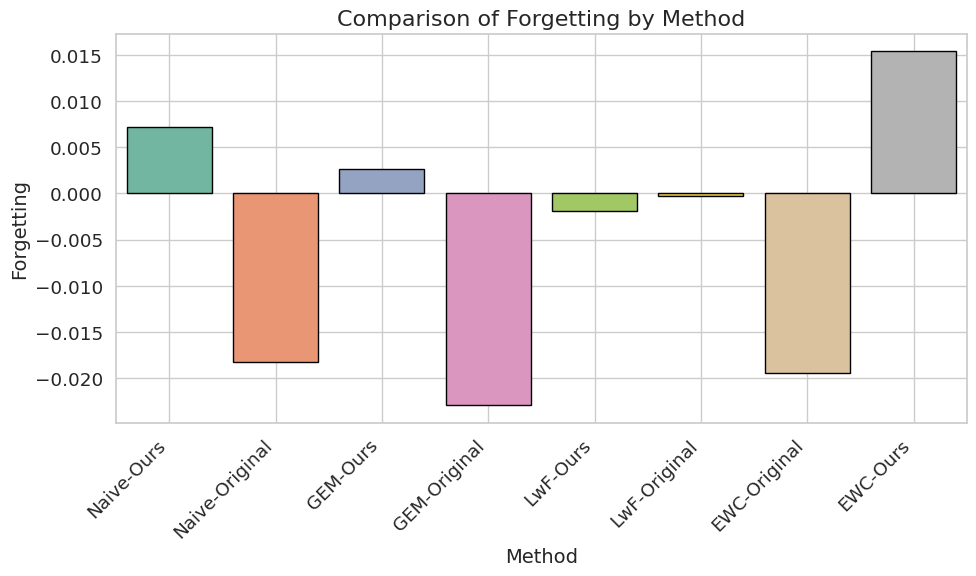

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_data is already created and contains the 'Method' and 'Forgetting' columns

# Set the plot style and figure size
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
plt.figure(figsize=(10, 6))

# Create a bar plot to visualize the forgetting for each method
ax = sns.barplot(
    x="Method", 
    y="Forgetting", 
    data=df, 
    ci=None,  # Remove confidence intervals
    palette="Set2", 
    edgecolor="black"
)

# Add plot labels and title
ax.set_xlabel("Method", fontsize=14)
ax.set_ylabel("Forgetting", fontsize=14)
ax.set_title("Comparison of Forgetting by Method", fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid lines for better readability of the y-axis values
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


In [488]:
# Define the desired KNN values and strategies
knn_values = [15, 20, 25, 30, 50]
strategies = ['Naive', 'GEM', 'LwF', 'EWC']
approaches = ['Ours', 'Original']

# Create a LaTeX table
latex_table = "\\begin{table}[hbtp]\n\\floatconts\n  {tab:example-booktabs}\n  {\\caption{Comparison of Strategies}}"
latex_table += "\n  {\\begin{tabular}{l" + "c" * (len(approaches) * len(strategies)) + "}\n  \\toprule\n"
latex_table += "  & \\multicolumn{2}{c}{\\bfseries Naive} & \\multicolumn{2}{c}{\\bfseries GEM} & \\multicolumn{2}{c}{\\bfseries LwF} & \\multicolumn{2}{c}{\\bfseries EWC}\\\\\n"
latex_table += "  \\bfseries KNN & \\textbf{\\bfseries Ours} & \\bfseries Original & \\textbf{\\bfseries Ours} & \\bfseries Original & \\textbf{\\bfseries Ours} & \\bfseries Original & \\textbf{\\bfseries Ours} & \\bfseries Original\\\\\n"
latex_table += "  \\midrule\n"

# Loop through each KNN value and generate the corresponding row in the LaTeX table
for knn in knn_values:
    latex_table += f"  {knn} "
    for strategy in strategies:
        for approach in approaches:
            # Extract the mean AMCA for the current strategy, approach, and KNN
            mean_amca = df[(df['Strategy'] == strategy) & (df['Method'].str.contains(approach)) & (df['KNN'] == knn)]['Mean AMCA']
            mean_amca = mean_amca.iloc[0] if not mean_amca.empty else "-"
            # Make the "Ours" column values bold
            if approach == 'Ours':
                latex_table += f"& \\textbf{{{mean_amca:.3f}}} " if mean_amca != "-" else "& \\textbf{-} "
            else:
                latex_table += f"& {mean_amca:.3f} " if mean_amca != "-" else "& - "
    latex_table += "\\\\\n"

latex_table += "  \\bottomrule\n  \\end{tabular}}\n\\end{table}"

# Print the LaTeX table
print(latex_table)

\begin{table}
\floatconts
  {tab:example-booktabs}
  {\caption{Comparison of Strategies}}
  {\begin{tabular}{lcccccccc}
  \toprule
  & \multicolumn{2}{c}{\bfseries Naive} & \multicolumn{2}{c}{\bfseries GEM} & \multicolumn{2}{c}{\bfseries LwF} & 
\multicolumn{2}{c}{\bfseries EWC}\\
  \bfseries KNN & \textbf{\bfseries Ours} & \bfseries Original & \textbf{\bfseries Ours} & \bfseries Original & 
\textbf{\bfseries Ours} & \bfseries Original & \textbf{\bfseries Ours} & \bfseries Original\\
  \midrule
  15 & \textbf{0.924} & 0.904 & \textbf{0.924} & 0.919 & \textbf{0.923} & 0.917 & \textbf{0.917} & 0.899 \\
  20 & \textbf{0.924} & 0.909 & \textbf{0.924} & 0.919 & \textbf{0.922} & 0.917 & \textbf{0.919} & 0.902 \\
  25 & \textbf{0.925} & 0.913 & \textbf{0.924} & 0.918 & \textbf{0.922} & 0.917 & \textbf{0.919} & 0.906 \\
  30 & \textbf{0.925} & 0.916 & \textbf{0.923} & 0.919 & \textbf{0.924} & 0.917 & \textbf{0.919} & 0.908 \\
  50 & \textbf{0.926} & 0.922 & \textbf{0.924} & 0.921 & \textbf{0.924} & 0.918 & \textbf{0.918} & 0.911 \\
  \bottomrule
  \end{tabular}}
\end{table}